### python /home/chp6257/PEFT/QALY-Tuning/progress-summary-qaly/merge_file.py

In [58]:
import os, glob, warnings, itertools
import pandas as pd, numpy as np
from sklearn.metrics import precision_score, roc_auc_score
from tqdm import tqdm

In [59]:
# ── CONFIG ──────────────────────────────────────────────────────────────
MODELS        = ['CHIEF'] # Current only CHIEF
SAMPLE_TYPES  = ['PM'] # Current only PM
BASE_ROOT_TMPL = "/n/data2/hms/dbmi/kyu/lab/chp6257/mutation_models/Age/TCGA/{model}/{sample}"
OUTPUT_PATH   = "/home/chp6257/PEFT/QALY-Tuning/output/ppv-output"
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [60]:
methods = {
    # frozen-feature baseline
    "baseline": {
        "postfix": "",
        "pattern": "4_*Percentage*_2"
    },
    # 64-d bottleneck adapter
    "adapter": {
        "postfix": "finetune_auroc-adapter-bottleneck-64_",
        "pattern": "4_*auroc-adapter-bottleneck-64_*"
    }
}

In [61]:
# Column order
BASELINE_COLS = ['prevalence', 'baseline_auroc', 'baseline']
ADAPTER_COLS  = ['adapter_auroc', 'adapter']
METRIC_ORDER  = BASELINE_COLS + ADAPTER_COLS
ID_COLS       = ['Cancer', 'Gene']

# final left→right order in the combined sheet
ID_ORDER = [f"{m}_{s}" for m in MODELS for s in SAMPLE_TYPES]

In [71]:
# ── HELPERS ─────────────────────────────────────────────────────────────
def parse_root(root_path: str):
    sample = os.path.basename(os.path.normpath(root_path))  # FS or PM
    model  = os.path.basename(os.path.dirname(root_path))   # e.g. CHIEF
    return model, sample

def id_from_root(root_path: str) -> str:
    m, s = parse_root(root_path)
    return f"{m}_{s}"                                     # e.g. CHIEF_FS

def compute_ppv_auroc_prevalence(folder):
    """Returns (ppv, auroc, prevalence) or (None,None,None)."""
    file = os.path.join(folder, "inference_results.csv")
    if not os.path.exists(file):
        # warnings.warn(f"File not found: {file}", RuntimeWarning)
        return None, None, None
    try:
        df = pd.read_csv(file)
        # ensure we have the right columns
        if not {'prob','label'}.issubset(df.columns):
            warnings.warn(f"Missing required columns in {file}. Found columns: {df.columns.tolist()}", RuntimeWarning)
            return None, None, None

        df['binary_pred'] = (df['prob'] >= 0.5).astype(int)
        ppv = precision_score(df['label'], df['binary_pred'])
        auroc = roc_auc_score(df['label'], df['prob'])
        prevalence = df['label'].mean()
        return ppv, auroc, prevalence

    except Exception as e:
        # warnings.warn(f"Failed on {folder}: {str(e)}", RuntimeWarning)
        return None, None, None


# ── BUILD MASTER INDEX ─────────────────────────────────────────────────
BASE_ROOT_LIST = [
    BASE_ROOT_TMPL.format(model=m, sample=s)
    for m, s in itertools.product(MODELS, SAMPLE_TYPES)
]

master_pairs = set()
for root in BASE_ROOT_LIST:
    for cancer in os.listdir(root):
        cpath = os.path.join(root, cancer)
        if not os.path.isdir(cpath):
            continue
        for folder in glob.glob(os.path.join(cpath, '*')):
            try:
                gene = os.path.basename(folder).split('_')[3].split('-')[0]
            except Exception:
                gene = "unknown"
            master_pairs.add((cancer, gene))

master_index = pd.MultiIndex.from_tuples(
    sorted(master_pairs), names=['Cancer', 'Gene']
)


# ── PER–MODEL+SAMPLE PASS ────────────────────────────────────────────────
for root in tqdm(BASE_ROOT_LIST, desc="8 roots"):
    model, sample = parse_root(root)
    ident         = f"{model}_{sample}"

    print(f"\n▶ Processing {ident}")
    # structure: results[method][cancer][gene] = list of (ppv, auroc, prev)
    results = {m: {} for m in methods}

    for cancer in os.listdir(root):
        cpath = os.path.join(root, cancer)
        if not os.path.isdir(cpath):
            continue

        for mname, info in methods.items():
            pattern = info['pattern']
            for folder in glob.glob(os.path.join(cpath, pattern)):
                # for baseline, only keep the “_2” replicates
                if mname == 'baseline' and not folder.rstrip('/').endswith('_2'):
                    continue

                try:
                    gene = os.path.basename(folder).split('_')[3].split('-')[0]
                except Exception:
                    gene = "unknown"

                ppv, auroc, prev = compute_ppv_auroc_prevalence(folder)
                if ppv is None:
                    continue

                results[mname]\
                    .setdefault(cancer, {})\
                    .setdefault(gene, [])\
                    .append((ppv, auroc, prev))


8 roots:   0%|          | 0/1 [00:00<?, ?it/s]


▶ Processing CHIEF_PM


/home/chp6257/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
8 roots: 100%|██████████| 1/1 [00:05<00:00,  5.14s/it]


In [72]:
import numpy as np
import pandas as pd

# helper to take the mean of metric idx (0=PPV, 1=AUROC, 2=Prevalence)
def mean_metric(method, cancer, gene, idx):
    vals = results.get(method, {}).get(cancer, {}).get(gene, [])
    if not vals:
        return np.nan
    return np.mean([v[idx] for v in vals])

# build rows
rows = []
for cancer, gene in master_index:
    rows.append({
        'Cancer': cancer,
        'Gene': gene,
        'Prevalence': mean_metric('baseline', cancer, gene, 2),
        'Baseline_AUROC': mean_metric('baseline', cancer, gene, 1),
        'Adapter_AUROC':  mean_metric('adapter',  cancer, gene, 1),
        'Baseline_PPV':   mean_metric('baseline', cancer, gene, 0),
        'Adapter_PPV':    mean_metric('adapter',  cancer, gene, 0),
    })

# create the DataFrame
df_result_PM = pd.DataFrame(rows)

# optional: sort for convenience
df_result_PM = df_result_PM.sort_values(['Cancer','Gene']).reset_index(drop=True)


In [73]:
df_result_PM.to_excel(os.path.join(OUTPUT_PATH,
               f"auroc_comparison_all_cancers_baseline_vs_adapter.xlsx"), index=False)


Number of genes in each AUROC band:
AUROC_Band      0.5 ≤ AUROC ≤ 0.635  AUROC < 0.5  AUROC > 0.635
Model                                                          
Adapter_AUROC                   143           42             22
Baseline_AUROC                  132           51             24


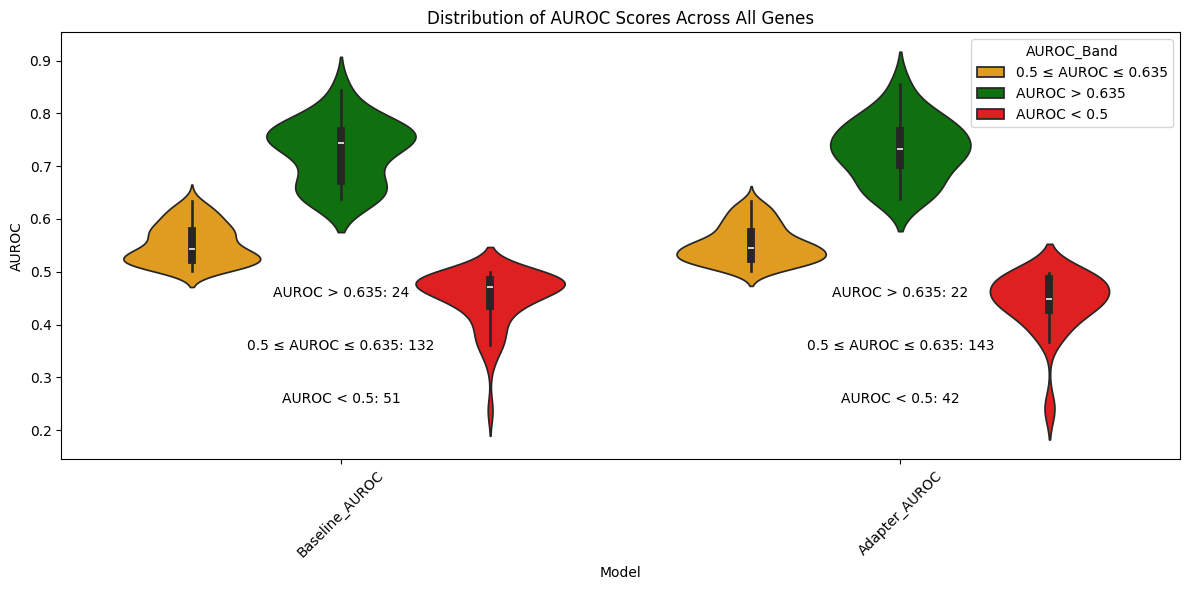

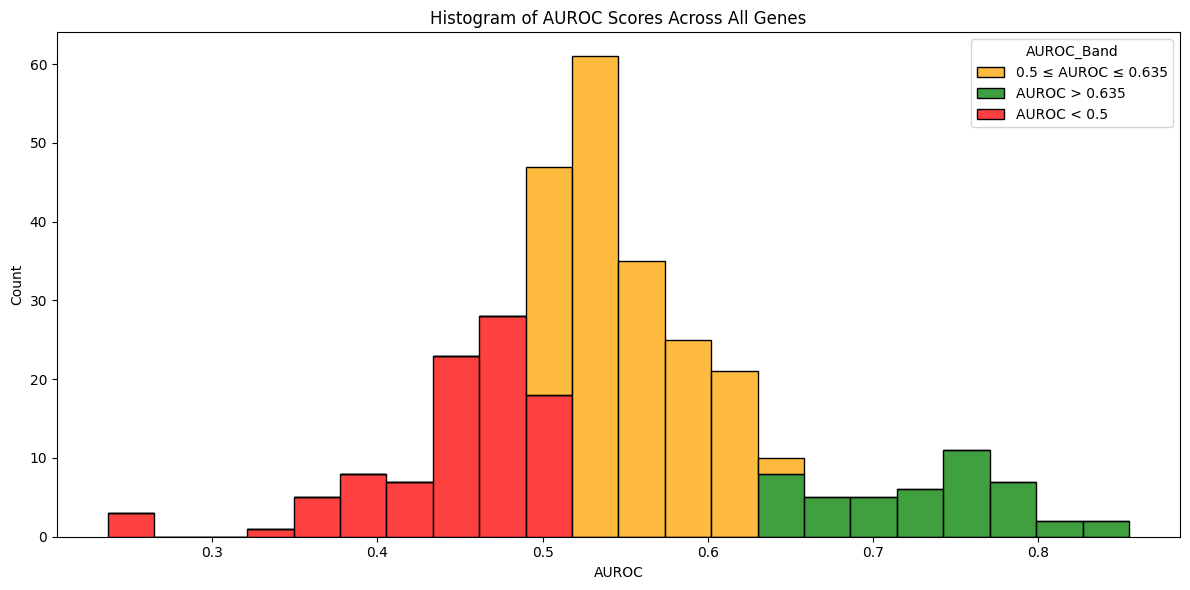


Detailed statistics for each band:

Baseline_AUROC:
AUROC < 0.5: 51 genes (24.6%)
0.5 ≤ AUROC ≤ 0.635: 132 genes (63.8%)
AUROC > 0.635: 24 genes (11.6%)

Adapter_AUROC:
AUROC < 0.5: 42 genes (20.3%)
0.5 ≤ AUROC ≤ 0.635: 143 genes (69.1%)
AUROC > 0.635: 22 genes (10.6%)


In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a new column for the AUROC bands
def get_auroc_band(auroc):
    if auroc < 0.5:
        return 'AUROC < 0.5'
    elif auroc > 0.635:
        return 'AUROC > 0.635'
    else:
        return '0.5 ≤ AUROC ≤ 0.635'

# Create a long format dataframe for both baseline and adapter AUROC
df_long = pd.melt(df_result_PM, 
                  id_vars=['Cancer', 'Gene'],
                  value_vars=['Baseline_AUROC', 'Adapter_AUROC'],
                  var_name='Model',
                  value_name='AUROC')

# Add the band information
df_long['AUROC_Band'] = df_long['AUROC'].apply(get_auroc_band)

# Calculate counts for each band and model
band_counts = df_long.groupby(['Model', 'AUROC_Band']).size().unstack(fill_value=0)
print("\nNumber of genes in each AUROC band:")
print(band_counts)

# Create the violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_long, x='Model', y='AUROC', hue='AUROC_Band', 
               palette={'AUROC < 0.5': 'red', 
                       '0.5 ≤ AUROC ≤ 0.635': 'orange',
                       'AUROC > 0.635': 'green'})

plt.title('Distribution of AUROC Scores Across All Genes')
plt.xticks(rotation=45)

# Add count annotations
for i, model in enumerate(['Baseline_AUROC', 'Adapter_AUROC']):
    for j, band in enumerate(['AUROC < 0.5', '0.5 ≤ AUROC ≤ 0.635', 'AUROC > 0.635']):
        count = band_counts.loc[model, band]
        plt.text(i, plt.ylim()[0] + (j+1)*0.1, f'{band}: {count}', 
                color='black', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=df_long, x='AUROC', hue='AUROC_Band', 
             palette={'AUROC < 0.5': 'red', 
                     '0.5 ≤ AUROC ≤ 0.635': 'orange',
                     'AUROC > 0.635': 'green'},
             multiple='stack')

plt.title('Histogram of AUROC Scores Across All Genes')
plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nDetailed statistics for each band:")
for model in ['Baseline_AUROC', 'Adapter_AUROC']:
    print(f"\n{model}:")
    for band in ['AUROC < 0.5', '0.5 ≤ AUROC ≤ 0.635', 'AUROC > 0.635']:
        count = band_counts.loc[model, band]
        percentage = (count / len(df_result_PM)) * 100
        print(f"{band}: {count} genes ({percentage:.1f}%)")

In [75]:
df = df_result_PM.dropna(subset=['Baseline_AUROC', 'Adapter_AUROC'])
df

,Cancer,Gene,Prevalence,Baseline_AUROC,Adapter_AUROC,Baseline_PPV,Adapter_PPV
1,acc,MUC16,0.164444,0.602933,0.524727,0.240741,0.156250
3,acc,TP53,0.195556,0.620166,0.617654,0.275862,0.343750
5,blca,FGFR2,0.033259,0.590979,0.489755,0.039216,0.000000
6,blca,FGFR3,0.188470,0.722147,0.725972,0.315152,0.529412
7,blca,KDM6A,0.301552,0.501517,0.518044,0.301980,0.311258
...,...,...,...,...,...,...,...
191,ucec,PIK3CA,0.530387,0.545752,0.527478,0.550000,0.574007
192,ucec,PTEN,0.657459,0.741935,0.744014,0.787500,0.783862
193,ucec,TP53,0.359116,0.683215,0.709210,0.502041,0.552239
194,ucec,TTN,0.390424,0.576284,0.554765,0.433735,0.426036


/tmp/ipykernel_43392/929522354.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Band'] = df['Baseline_AUROC'].apply(band)
/tmp/ipykernel_43392/929522354.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AUROC_Improvement'] = df['Adapter_AUROC'] - df['Baseline_AUROC']


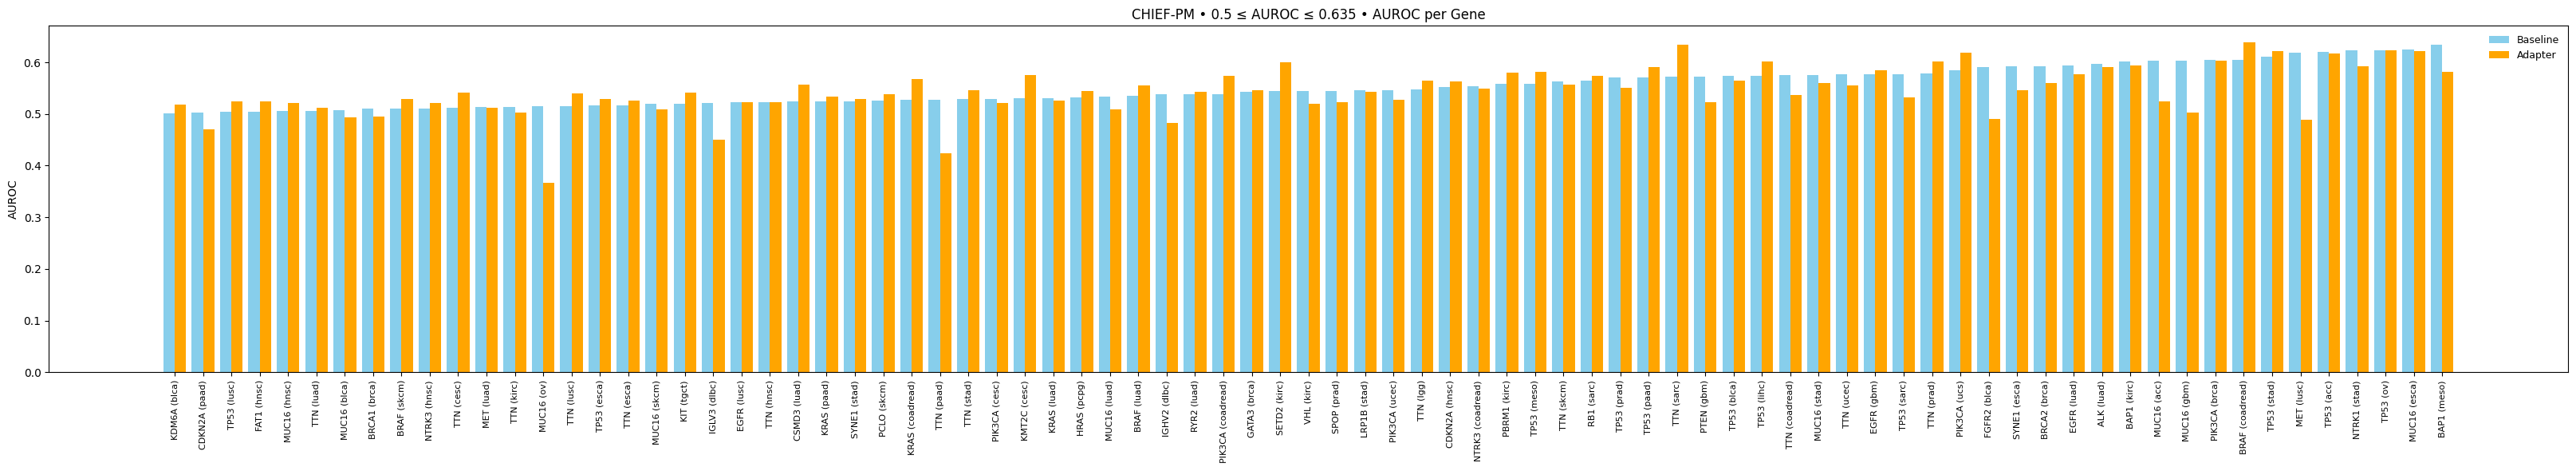

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


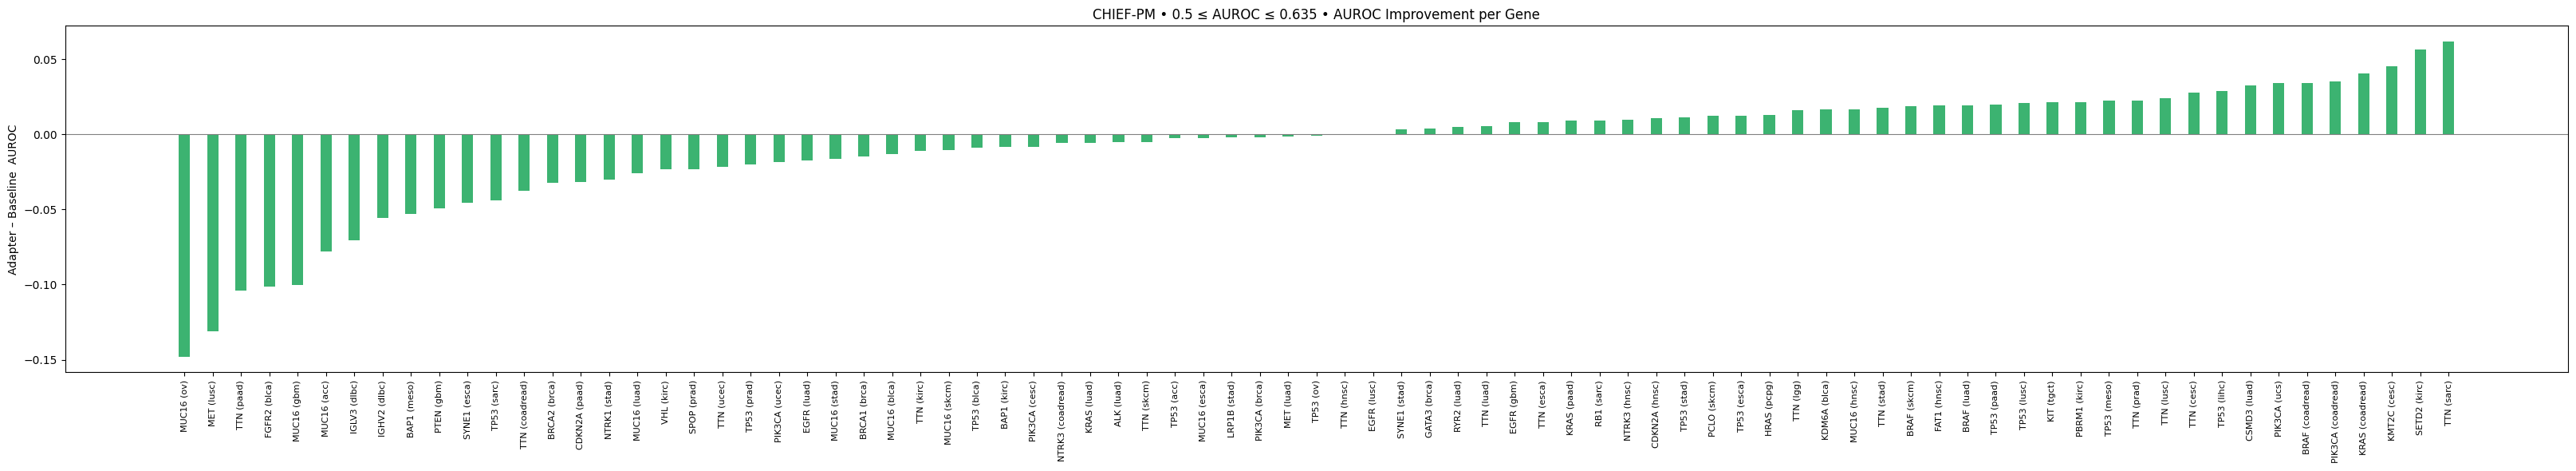

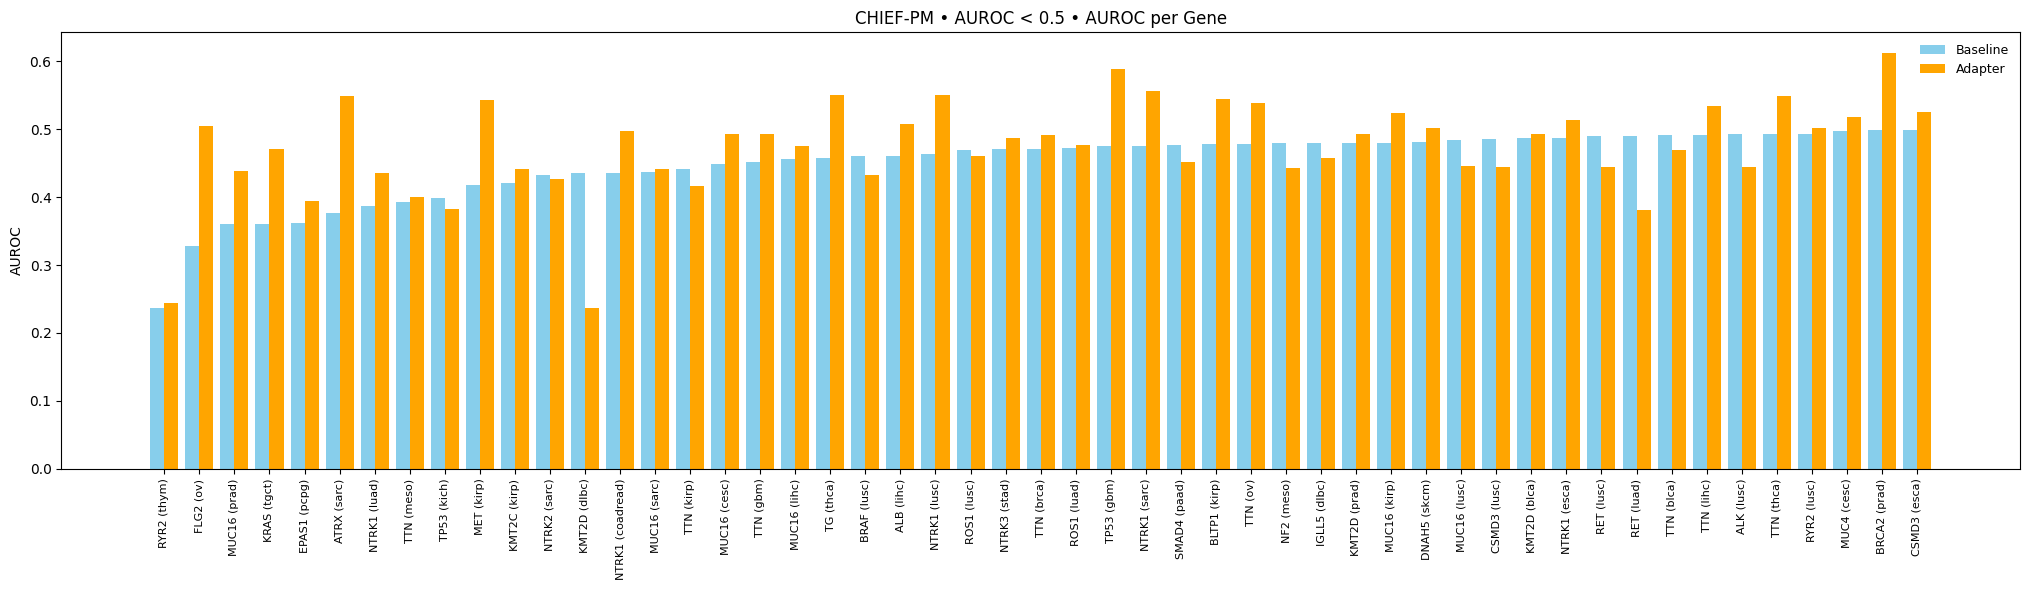

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


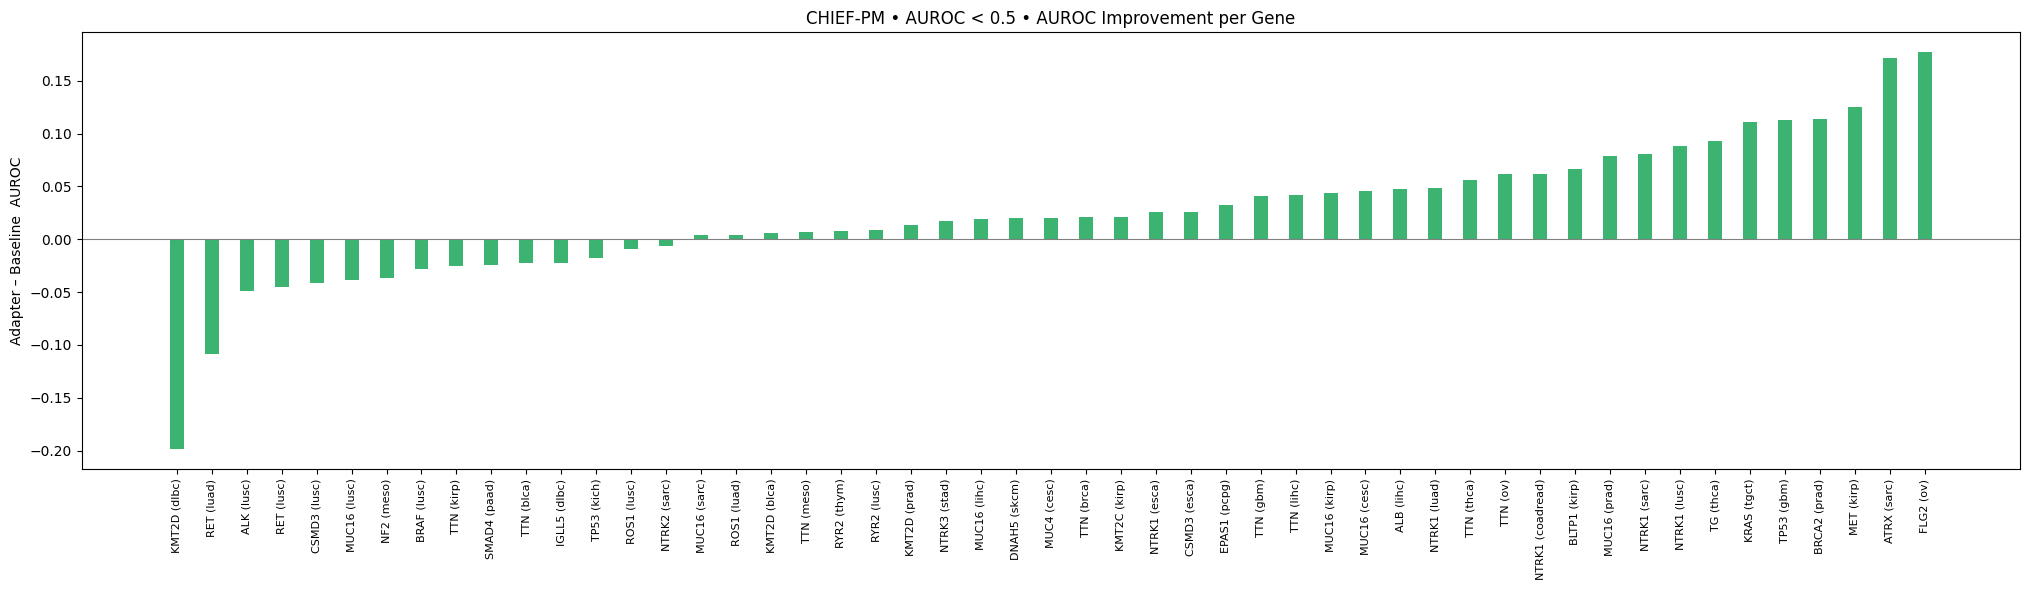

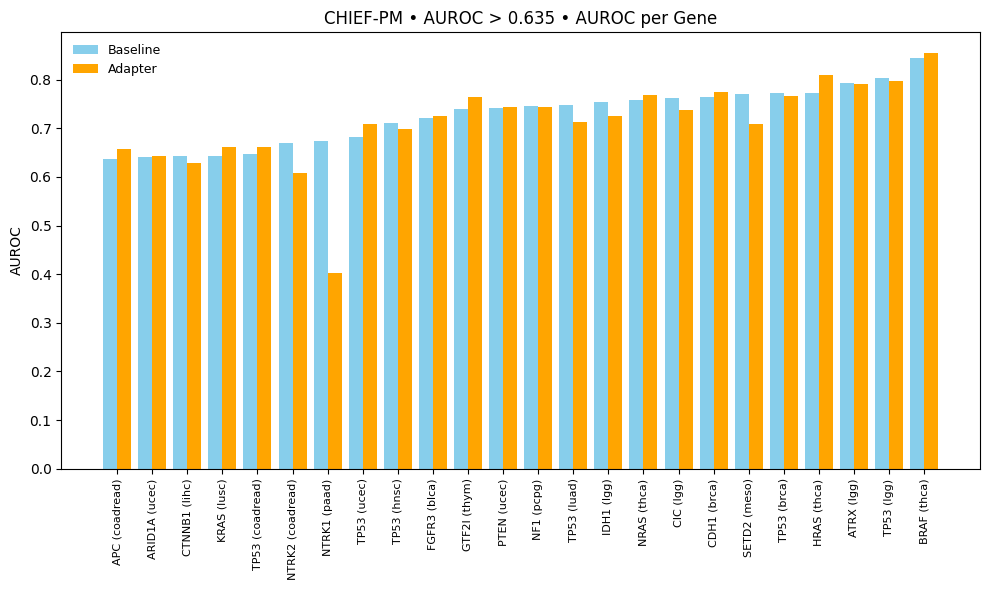

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


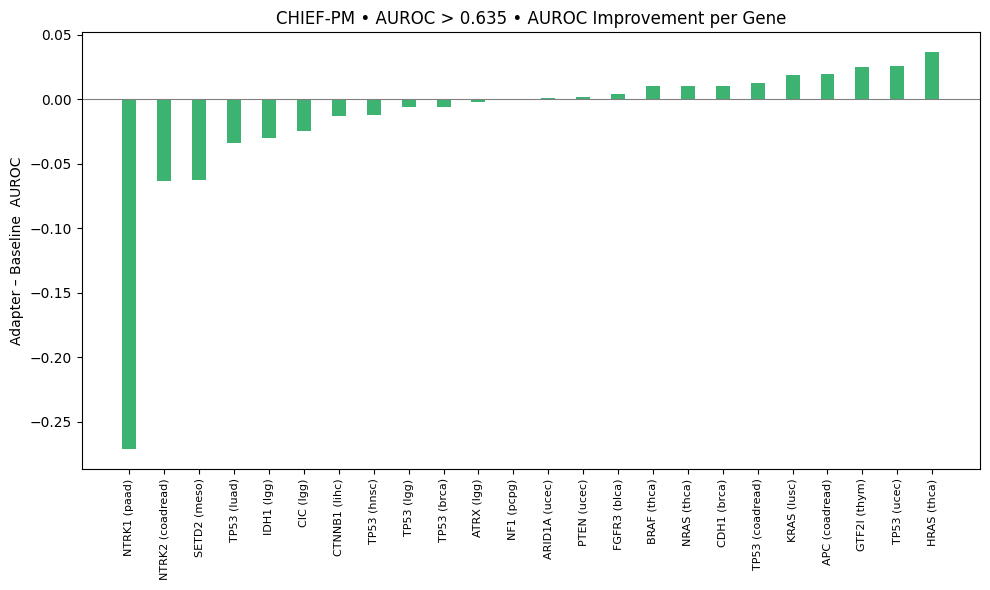

In [76]:
# ============================================================
#  CHIEF-PM  •  AUROC bands  •  per-gene bar-plots
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------------
#  band assignment helper
# ------------------------------------------------------------------
def band(a):
    if a < 0.5:          return 'AUROC < 0.5'
    elif a > 0.635:      return 'AUROC > 0.635'
    else:                return '0.5 ≤ AUROC ≤ 0.635'

df['Band'] = df['Baseline_AUROC'].apply(band)

# ------------------------------------------------------------------
#  improvement column  (positive = better)
# ------------------------------------------------------------------
df['AUROC_Improvement'] = df['Adapter_AUROC'] - df['Baseline_AUROC']

# ------------------------------------------------------------------
#  plotting function
# ------------------------------------------------------------------
def plot_band(data, metric, title, color_base='skyblue', color_adapt='orange'):
    """
    metric = 'AUROC'  or  'Improvement'
    If 'AUROC'  → grouped bars (baseline vs adapter)
    If 'Improvement' → single bars (delta)
    """
    genes = data['Gene'] + ' (' + data['Cancer'] + ')'   # label with cancer too
    x = np.arange(len(genes))
    bar_w = 0.4

    plt.figure(figsize=(max(10, len(genes)*0.4), 6))
    if metric == 'AUROC':
        plt.bar(x - bar_w/2, data['Baseline_AUROC'], bar_w, label='Baseline', color=color_base)
        plt.bar(x + bar_w/2, data['Adapter_AUROC'],  bar_w, label='Adapter',  color=color_adapt)
        plt.ylabel('AUROC')
    else:  # Improvement
        plt.bar(x, data['AUROC_Improvement'], bar_w, color='mediumseagreen')
        plt.axhline(0, color='gray', lw=0.8)
        plt.ylabel('Adapter – Baseline  AUROC')

    plt.xticks(x, genes, rotation=90, fontsize=8)
    plt.title(title)
    plt.tight_layout()
    plt.legend(fontsize=9, frameon=False)
    plt.show()


# ------------------------------------------------------------------
#  loop over the 3 bands  →  6 plots (AUROC & Improvement)
# ------------------------------------------------------------------
for band_name, g in df.groupby('Band'):
    g_sorted = g.sort_values('Baseline_AUROC')           # or any ordering you prefer
    # AUROC grouped bars
    plot_band(g_sorted, metric='AUROC',
              title=f"CHIEF-PM • {band_name} • AUROC per Gene")

    # Improvement bars
    g_sorted = g.sort_values('AUROC_Improvement')
    plot_band(g_sorted, metric='Improvement',
              title=f"CHIEF-PM • {band_name} • AUROC Improvement per Gene")


/tmp/ipykernel_43392/1996016893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AUROC_Improvement'] = df['Adapter_AUROC'] - df['Baseline_AUROC']


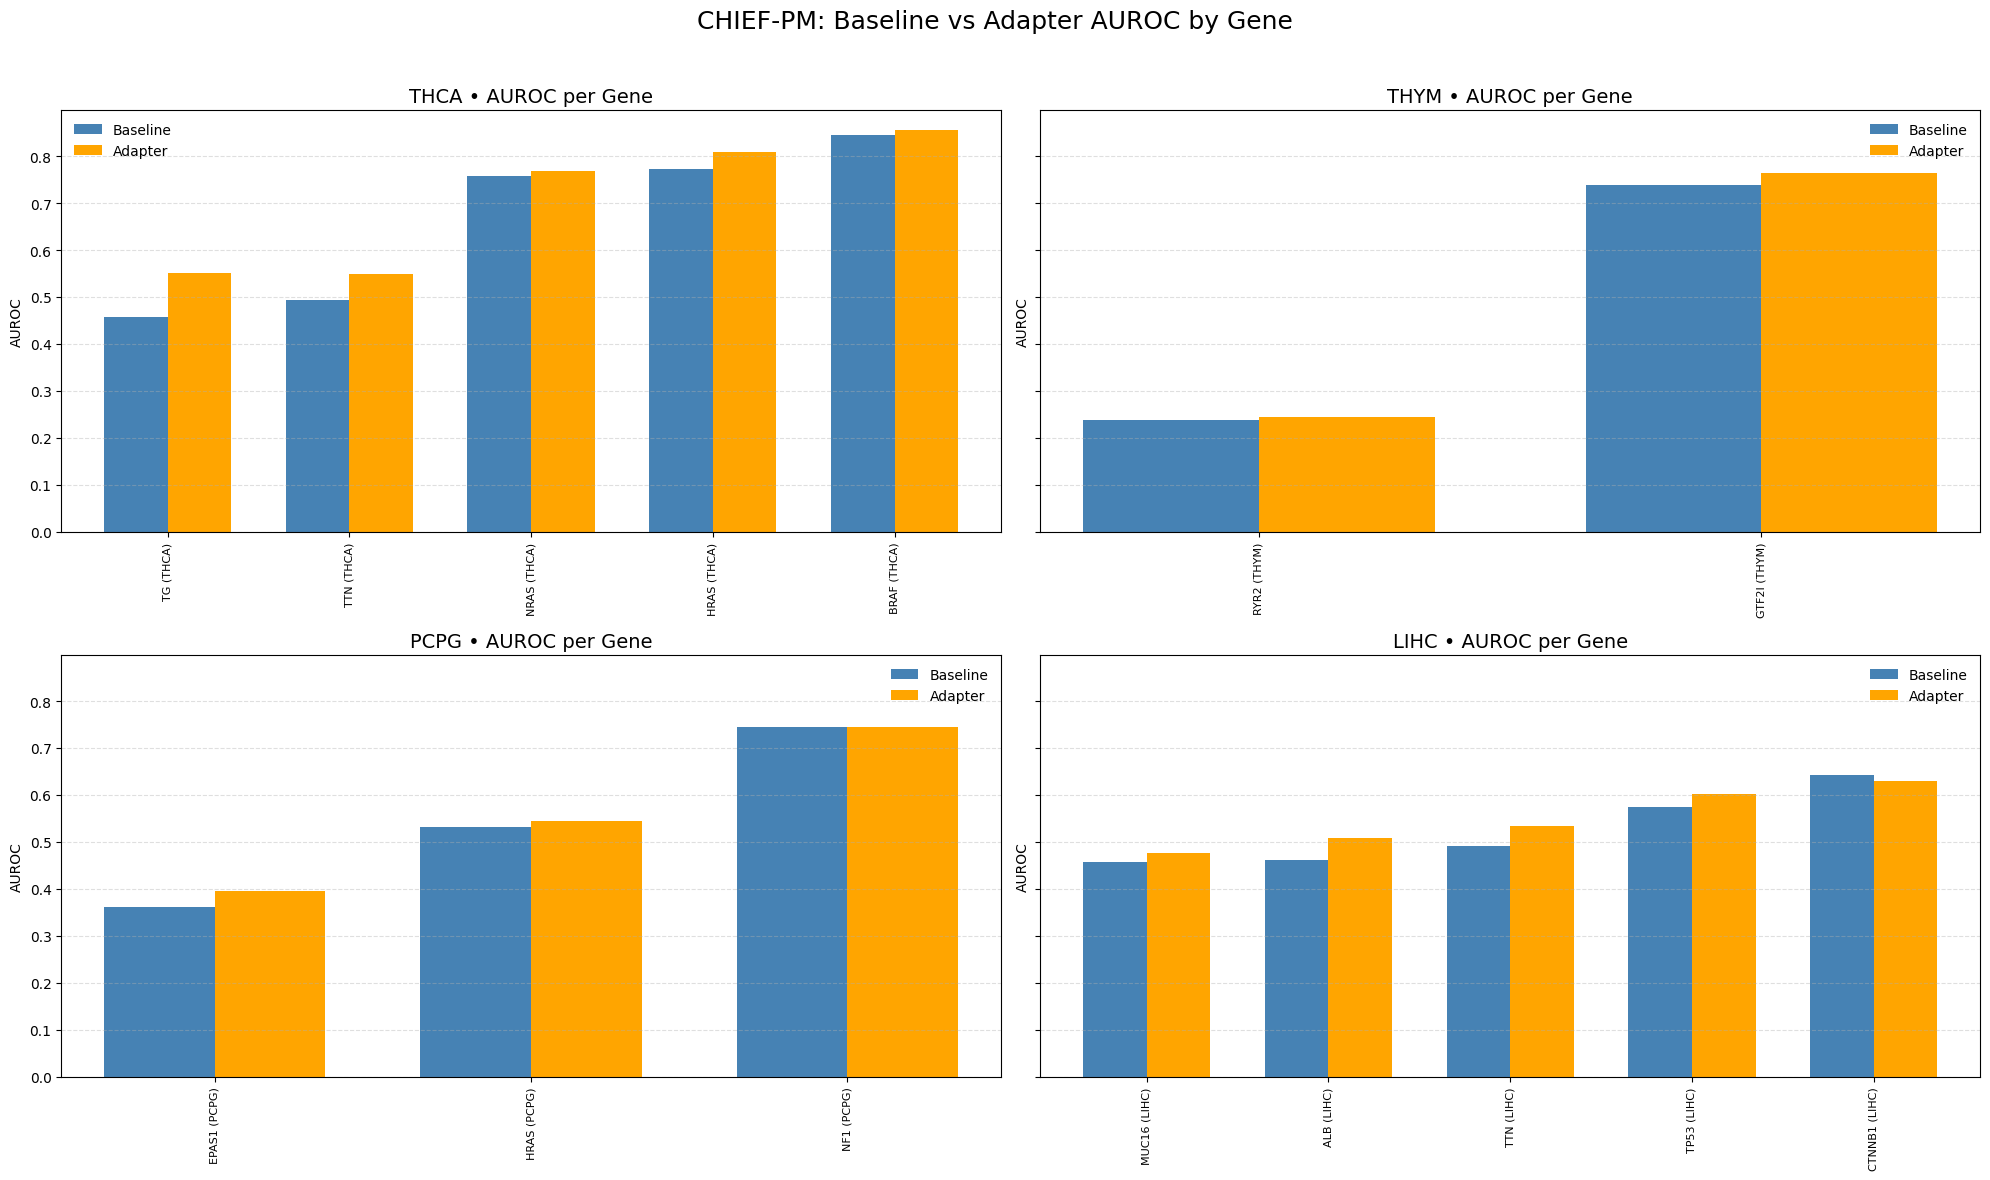

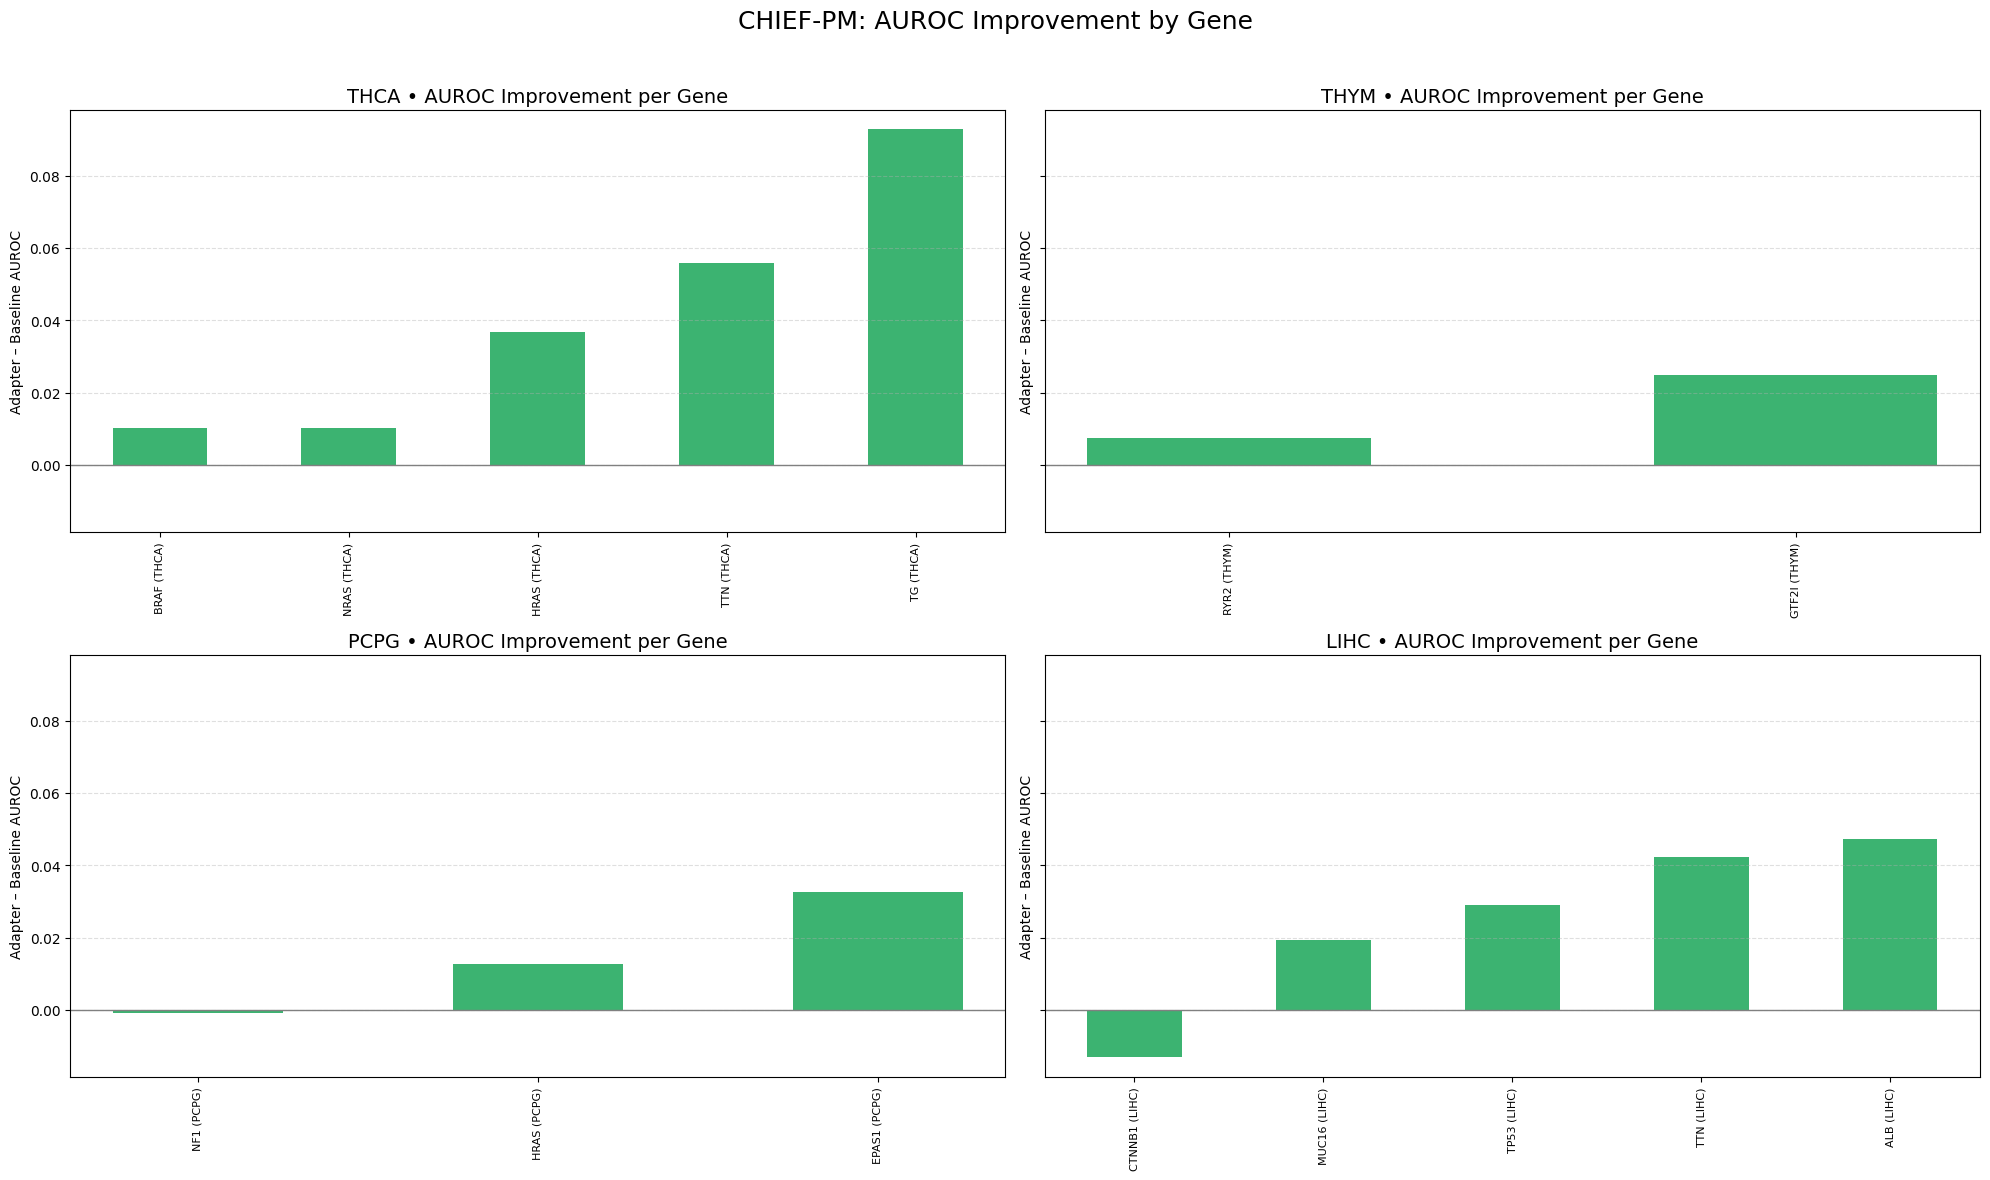

In [77]:
df['AUROC_Improvement'] = df['Adapter_AUROC'] - df['Baseline_AUROC']

# ------------------------------------------------------------------
#  Only these four cancers (df['Cancer'] is lowercase)
# ------------------------------------------------------------------
selected = ['thca', 'thym', 'pcpg', 'lihc']

# ------------------------------------------------------------------
#  1) AUROC comparison figure (2×2 grid)
# ------------------------------------------------------------------
fig1, axes1 = plt.subplots(2, 2, figsize=(20, 12), sharey=True)
for ax, cancer in zip(axes1.flatten(), selected):
    sub = df[df['Cancer'] == cancer].sort_values('Baseline_AUROC')
    genes = sub['Gene'] + f" ({cancer.upper()})"
    x = np.arange(len(genes))
    w = 0.35

    ax.bar(x - w/2, sub['Baseline_AUROC'], w, label='Baseline', color='steelblue')
    ax.bar(x + w/2, sub['Adapter_AUROC'],  w, label='Adapter',  color='orange')
    ax.set_title(f"{cancer.upper()} • AUROC per Gene", fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(genes, rotation=90, fontsize=8)
    ax.set_ylabel('AUROC')
    ax.legend(frameon=False, fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.4)

fig1.suptitle("CHIEF-PM: Baseline vs Adapter AUROC by Gene", fontsize=18)
fig1.tight_layout(rect=[0,0,1,0.96])
plt.show()

# ------------------------------------------------------------------
#  2) Improvement figure (2×2 grid)
# ------------------------------------------------------------------
fig2, axes2 = plt.subplots(2, 2, figsize=(20, 12), sharey=True)
for ax, cancer in zip(axes2.flatten(), selected):
    sub = df[df['Cancer'] == cancer].sort_values('AUROC_Improvement')
    genes = sub['Gene'] + f" ({cancer.upper()})"
    x = np.arange(len(genes))
    w = 0.5

    ax.bar(x, sub['AUROC_Improvement'], w, color='mediumseagreen')
    ax.axhline(0, color='gray', lw=1)
    ax.set_title(f"{cancer.upper()} • AUROC Improvement per Gene", fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(genes, rotation=90, fontsize=8)
    ax.set_ylabel('Adapter – Baseline AUROC')
    ax.grid(axis='y', linestyle='--', alpha=0.4)

fig2.suptitle("CHIEF-PM: AUROC Improvement by Gene", fontsize=18)
fig2.tight_layout(rect=[0,0,1,0.96])
plt.show()


/tmp/ipykernel_43392/1637758748.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AUROC_Improvement'] = df['Adapter_AUROC'] - df['Baseline_AUROC']


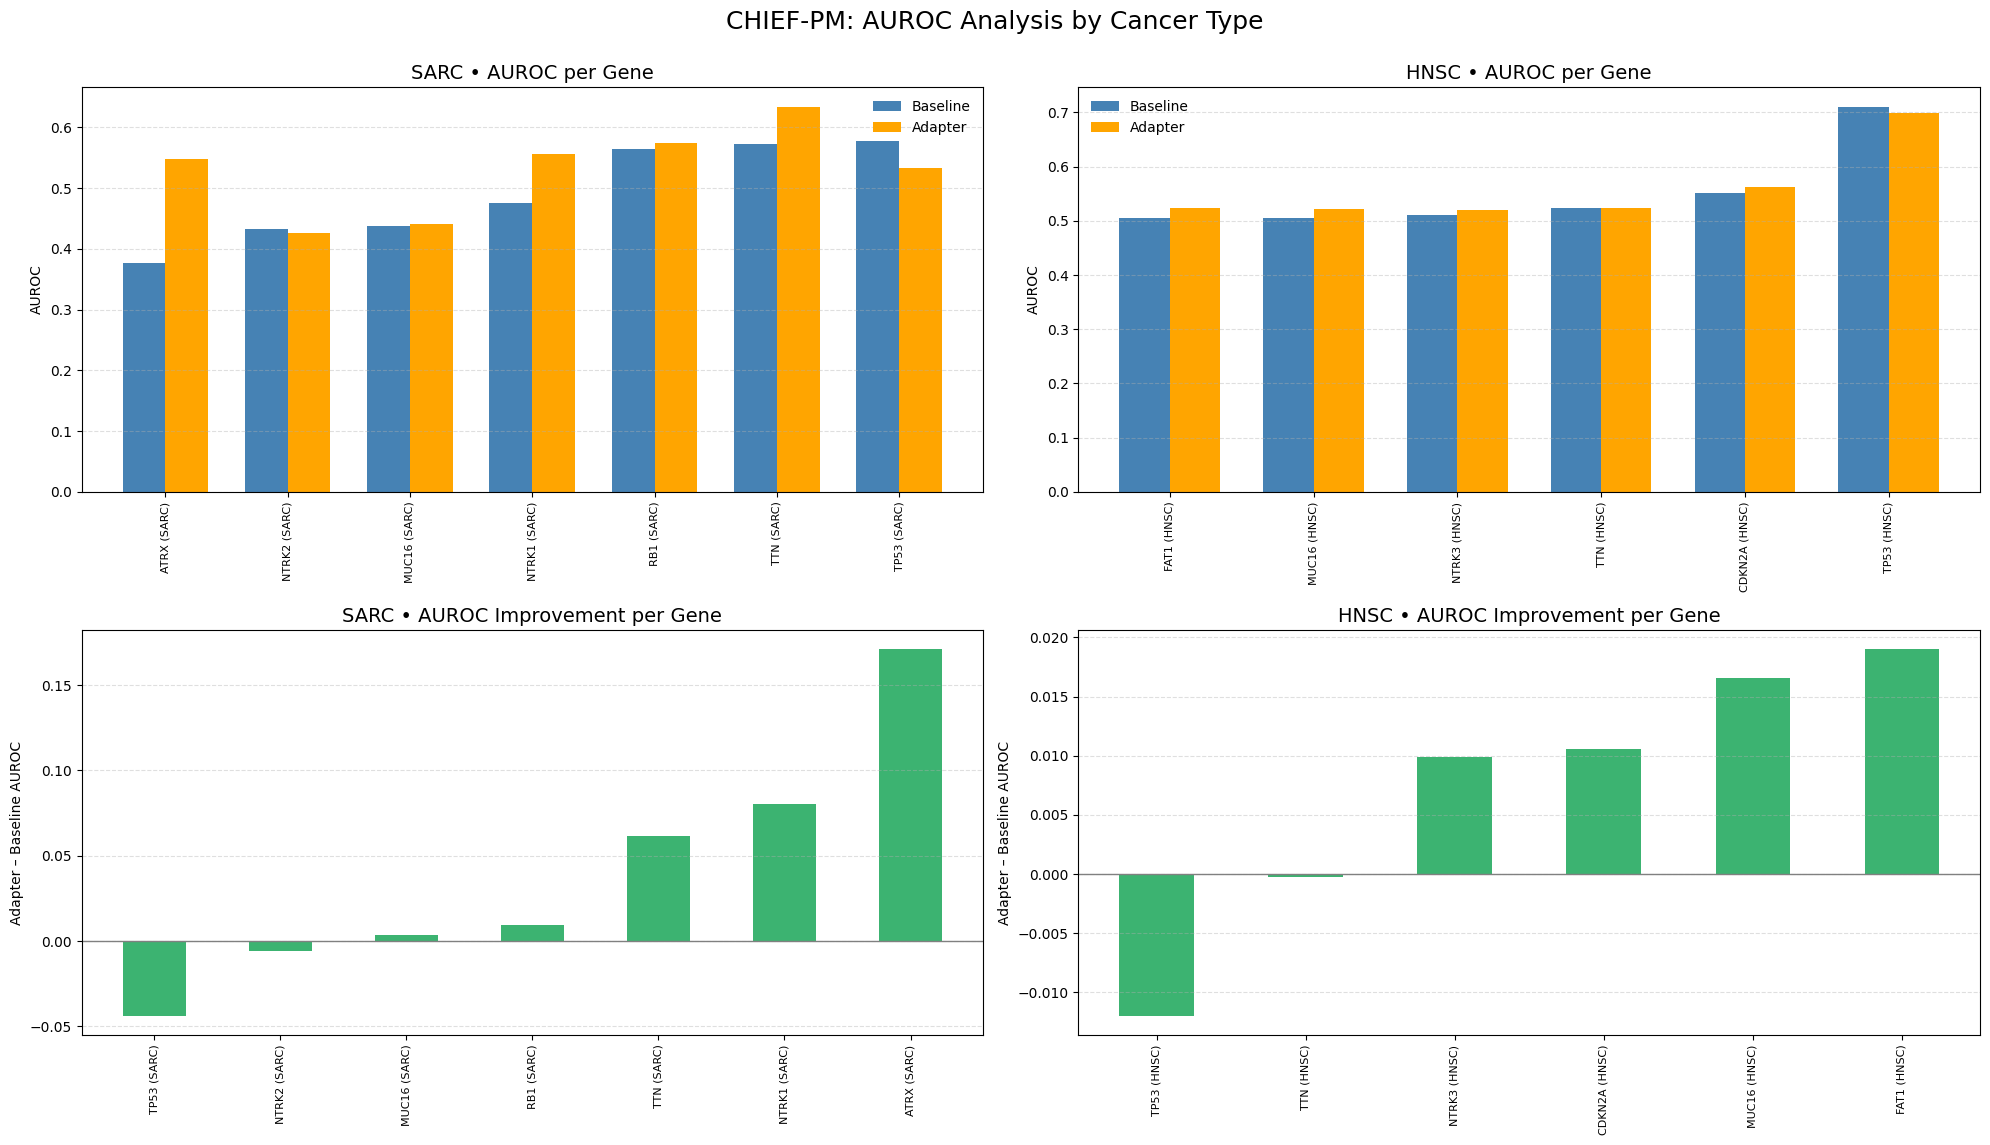

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df['AUROC_Improvement'] = df['Adapter_AUROC'] - df['Baseline_AUROC']

# ------------------------------------------------------------------
#  Only these two cancers (df['Cancer'] is lowercase)
# ------------------------------------------------------------------
selected = ['sarc', 'hnsc']

# ------------------------------------------------------------------
#  Create a single figure with 4 subplots (2×2 grid)
# ------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle("CHIEF-PM: AUROC Analysis by Cancer Type", fontsize=18, y=0.95)

# First row: AUROC comparison
for i, cancer in enumerate(selected):
    sub = df[df['Cancer'] == cancer].sort_values('Baseline_AUROC')
    genes = sub['Gene'] + f" ({cancer.upper()})"
    x = np.arange(len(genes))
    w = 0.35

    # AUROC comparison plot
    axes[0, i].bar(x - w/2, sub['Baseline_AUROC'], w, label='Baseline', color='steelblue')
    axes[0, i].bar(x + w/2, sub['Adapter_AUROC'], w, label='Adapter', color='orange')
    axes[0, i].set_title(f"{cancer.upper()} • AUROC per Gene", fontsize=14)
    axes[0, i].set_xticks(x)
    axes[0, i].set_xticklabels(genes, rotation=90, fontsize=8)
    axes[0, i].set_ylabel('AUROC')
    axes[0, i].legend(frameon=False, fontsize=10)
    axes[0, i].grid(axis='y', linestyle='--', alpha=0.4)

# Second row: AUROC improvement
for i, cancer in enumerate(selected):
    sub = df[df['Cancer'] == cancer].sort_values('AUROC_Improvement')
    genes = sub['Gene'] + f" ({cancer.upper()})"
    x = np.arange(len(genes))
    w = 0.5

    # Improvement plot
    axes[1, i].bar(x, sub['AUROC_Improvement'], w, color='mediumseagreen')
    axes[1, i].axhline(0, color='gray', lw=1)
    axes[1, i].set_title(f"{cancer.upper()} • AUROC Improvement per Gene", fontsize=14)
    axes[1, i].set_xticks(x)
    axes[1, i].set_xticklabels(genes, rotation=90, fontsize=8)
    axes[1, i].set_ylabel('Adapter – Baseline AUROC')
    axes[1, i].grid(axis='y', linestyle='--', alpha=0.4)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

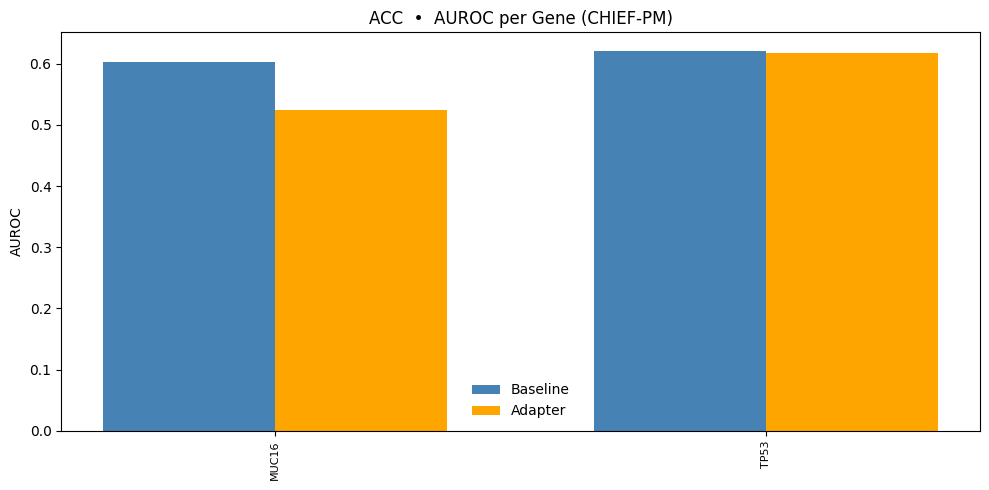

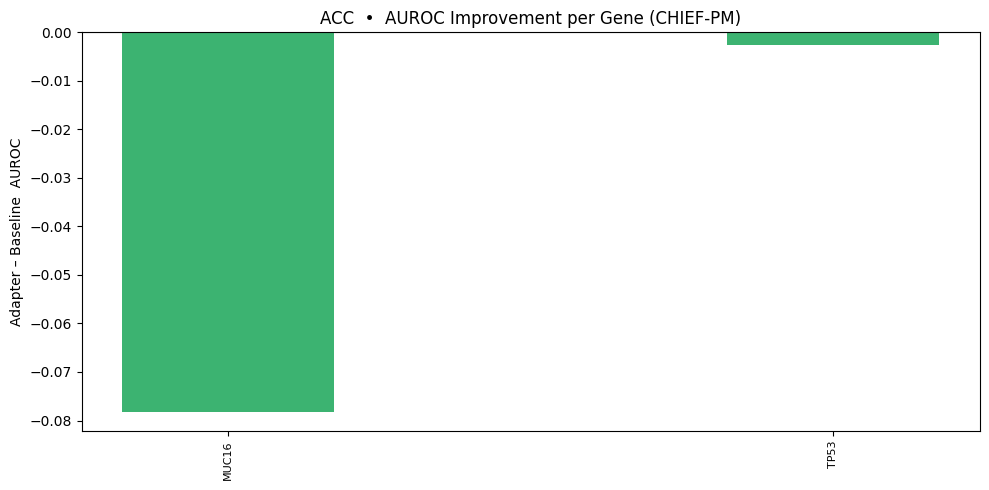

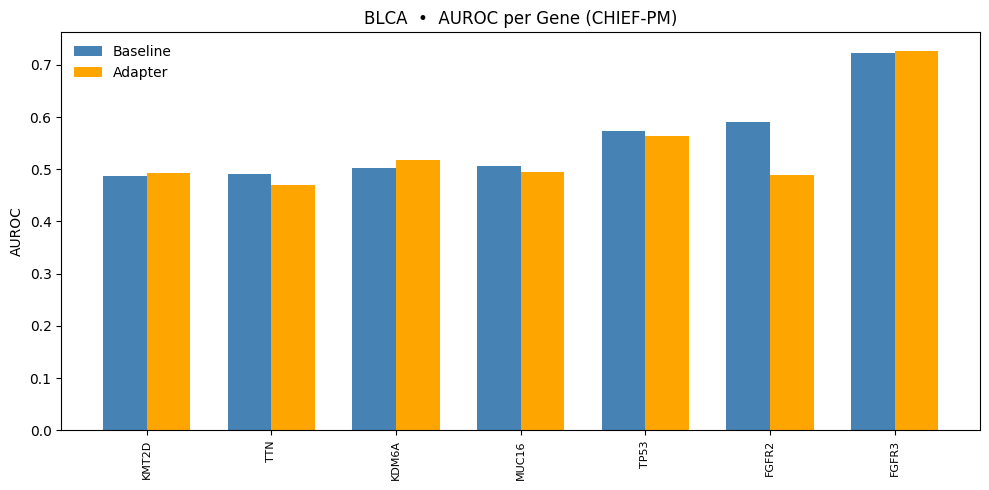

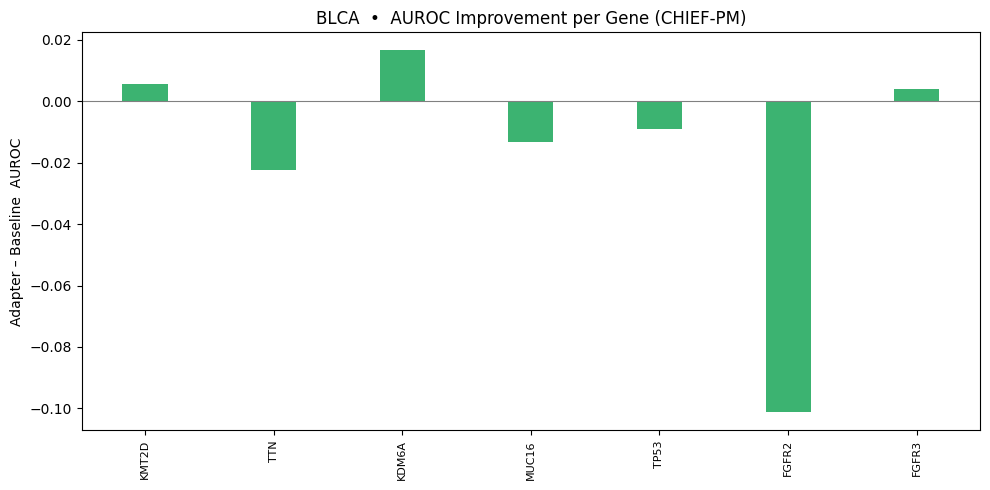

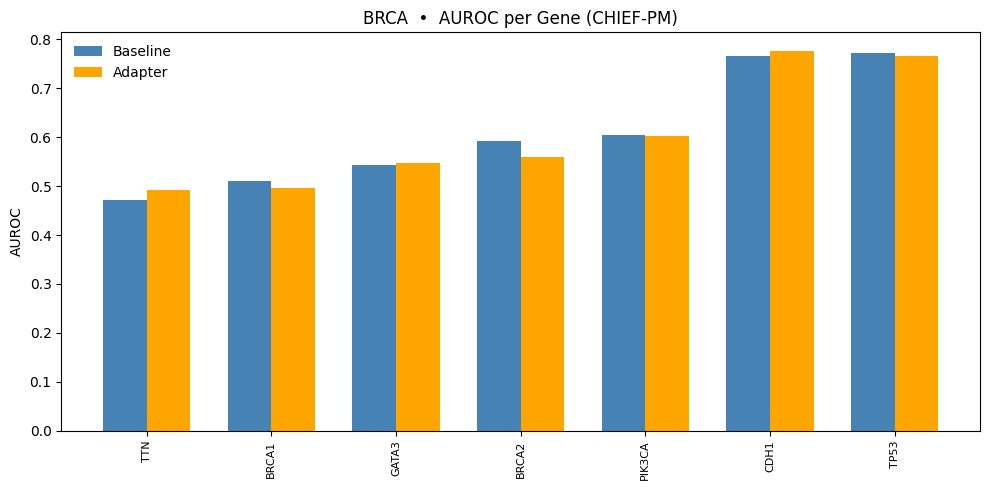

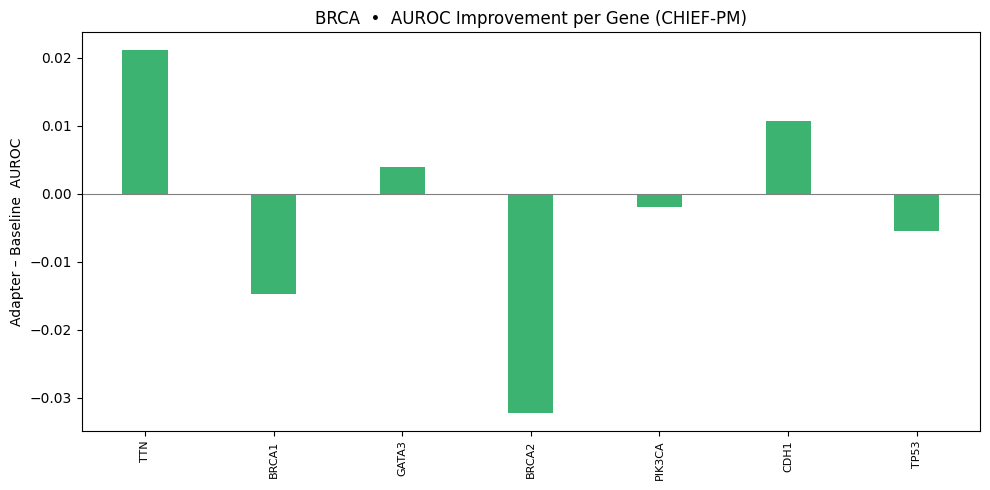

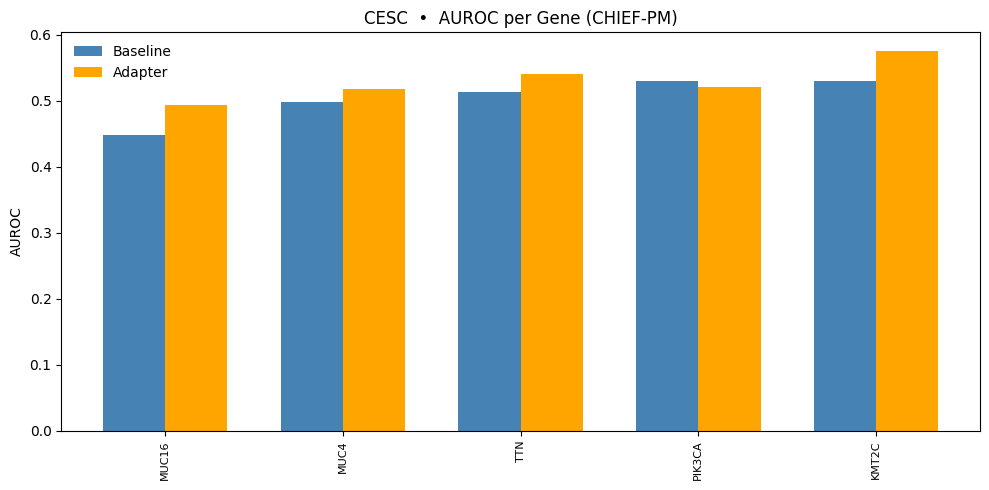

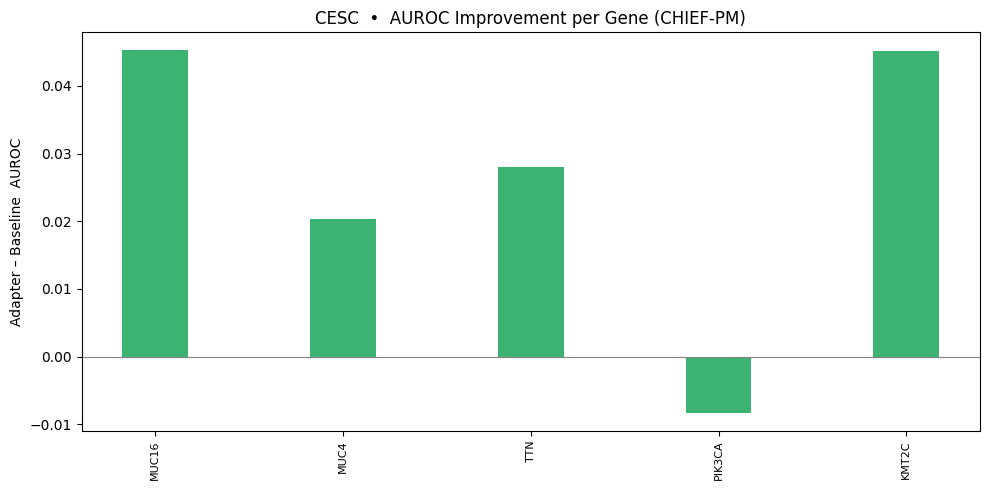

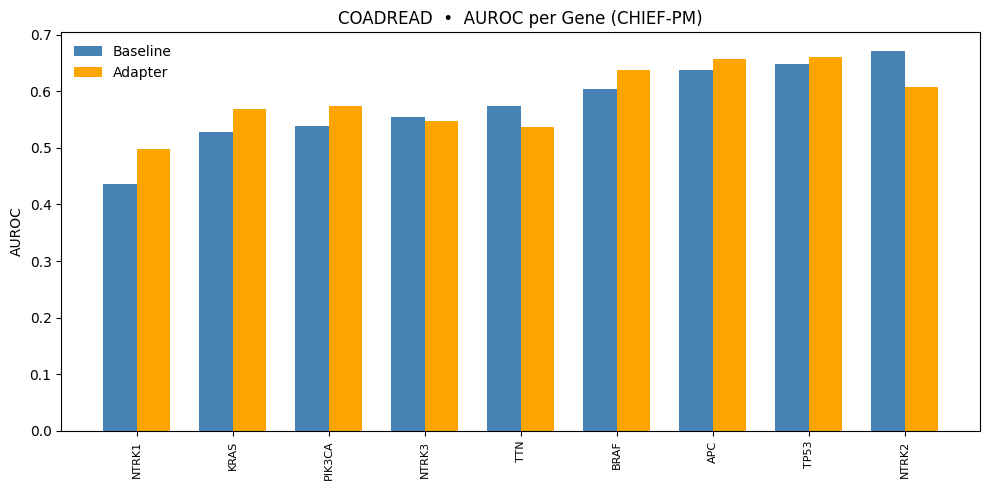

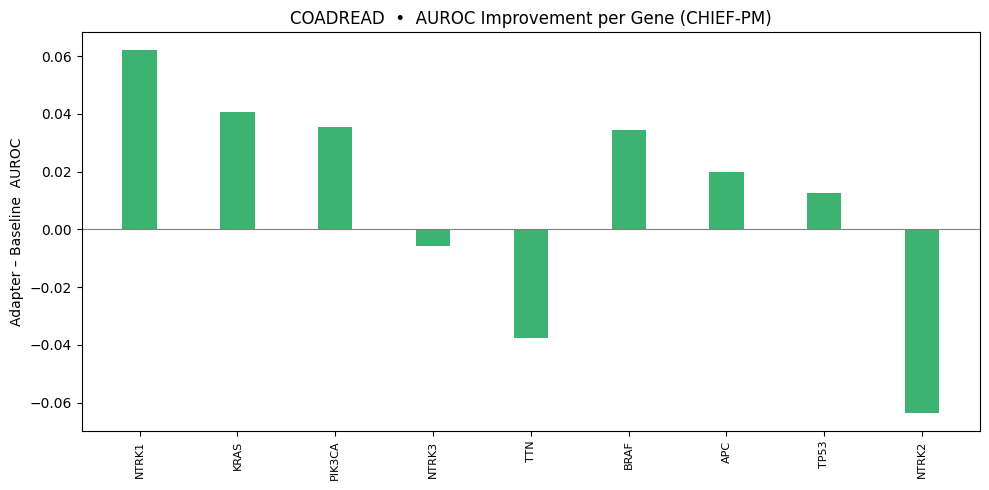

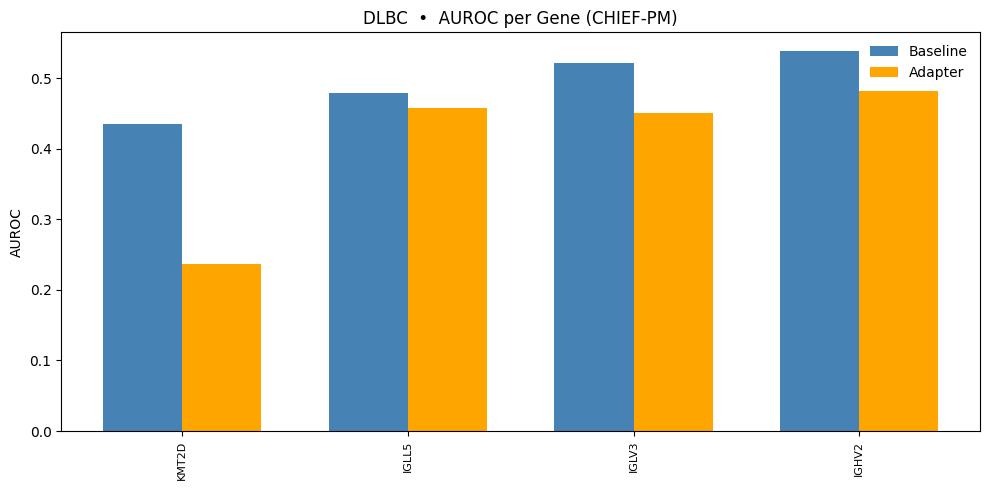

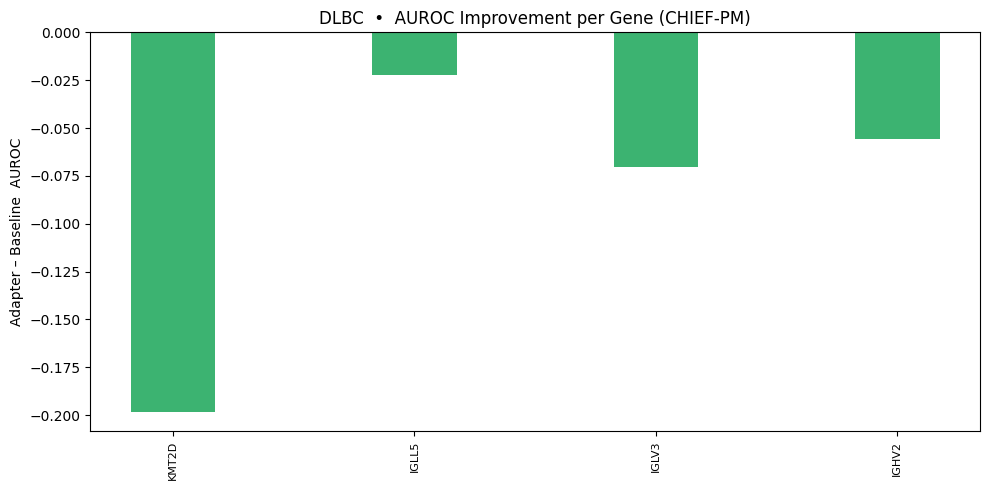

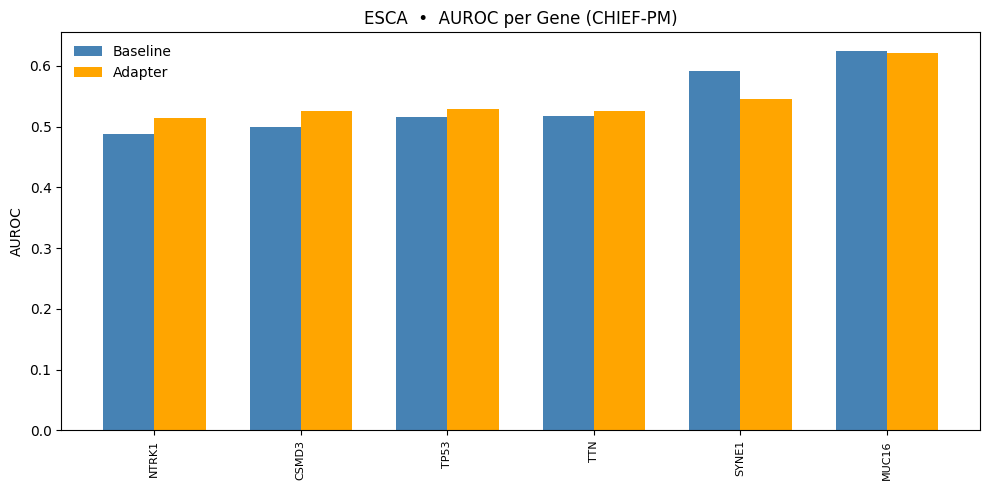

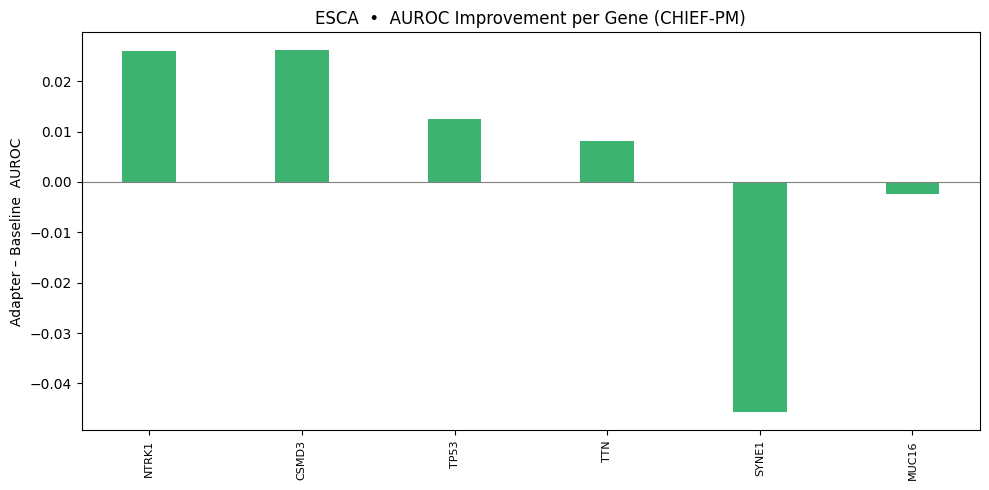

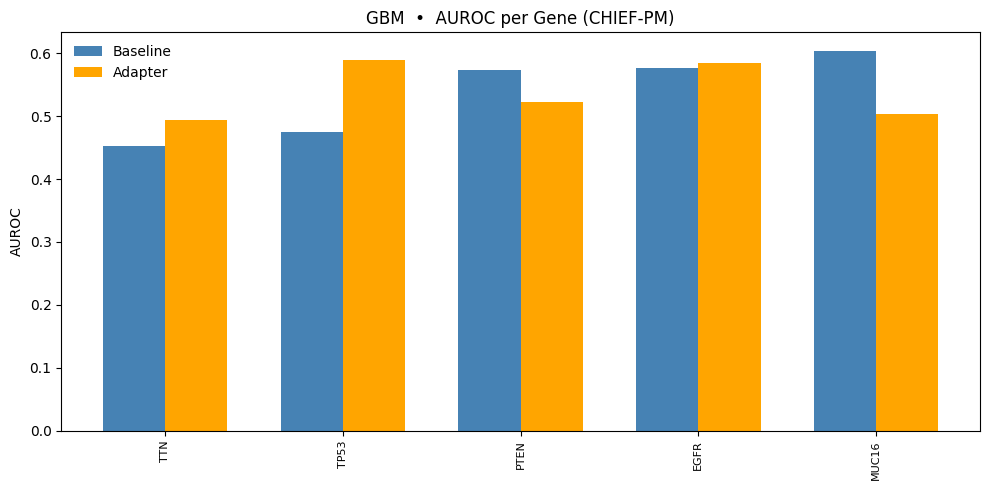

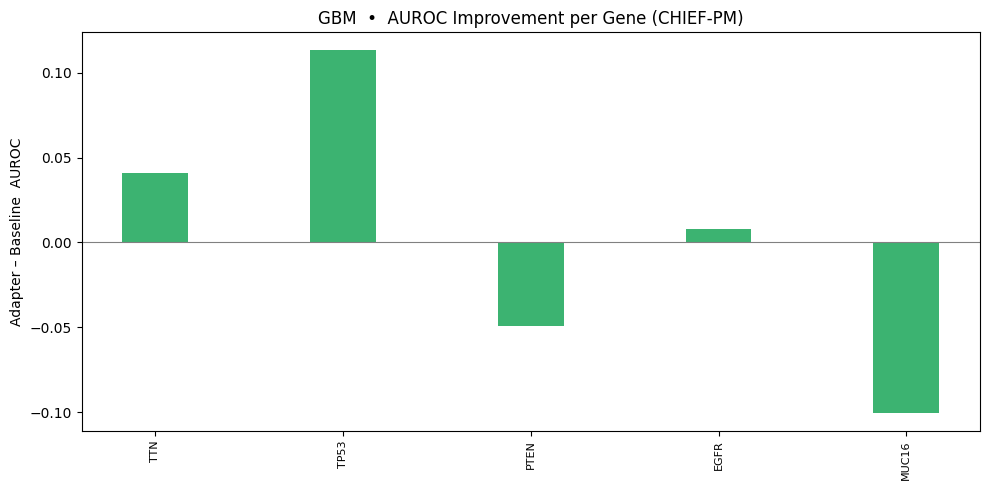

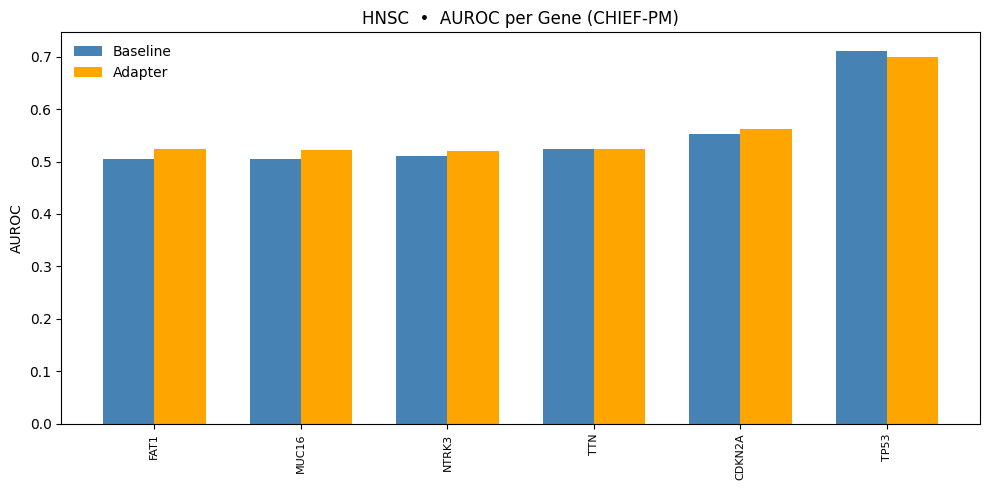

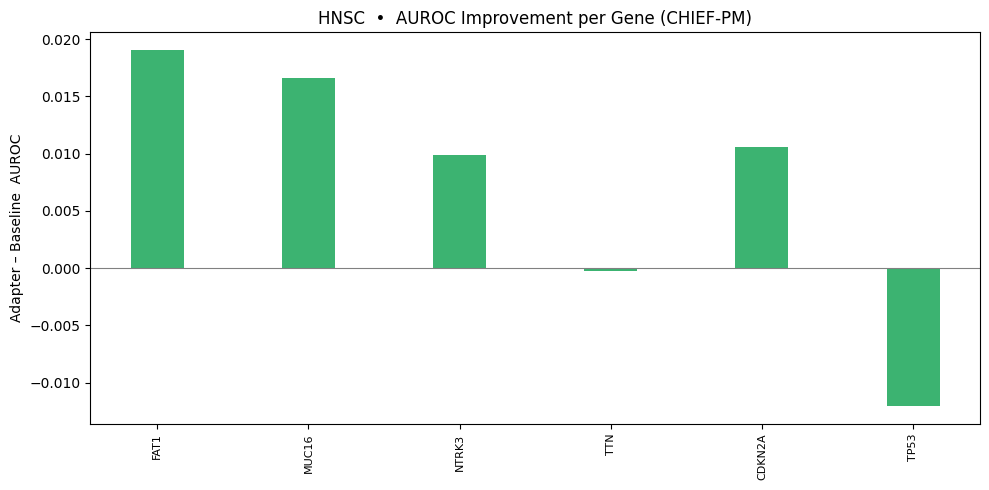

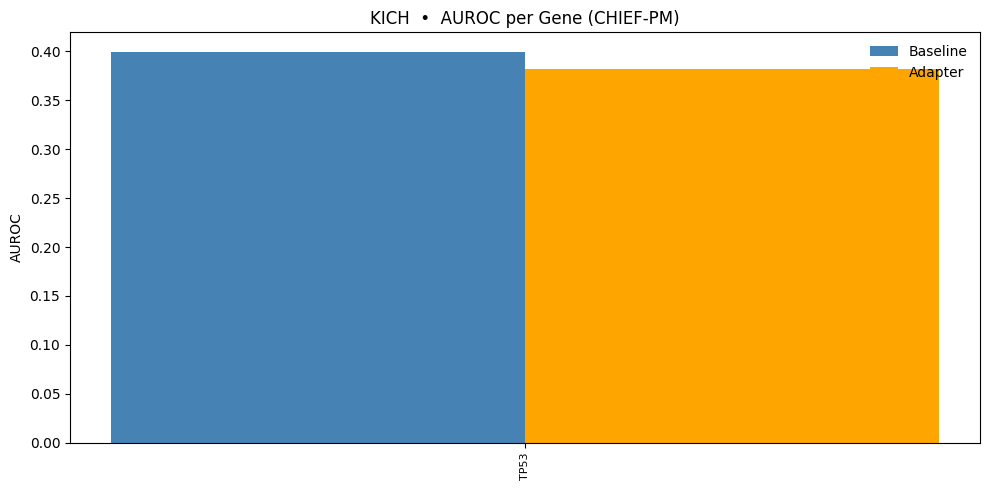

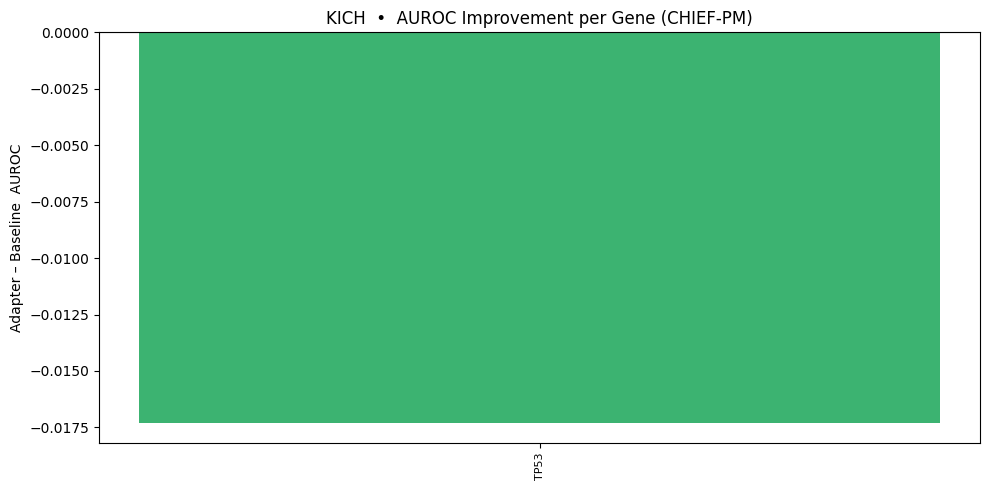

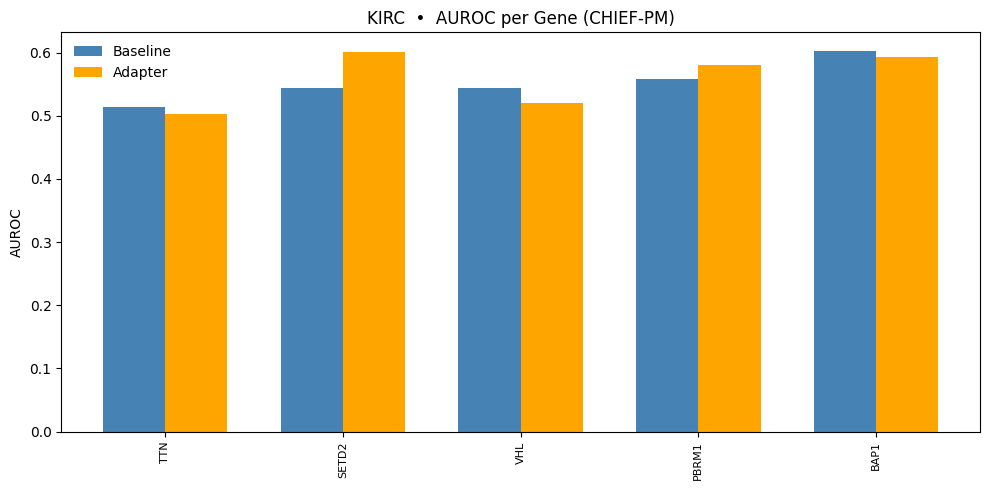

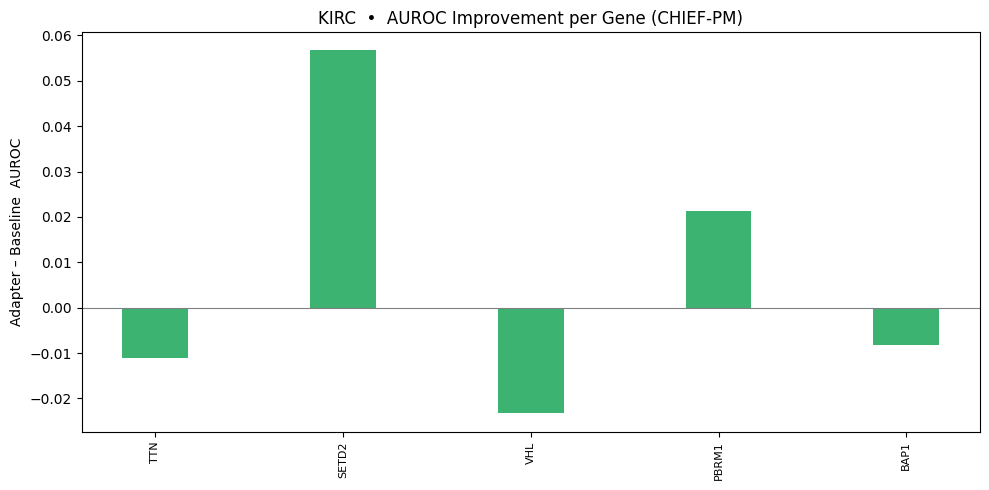

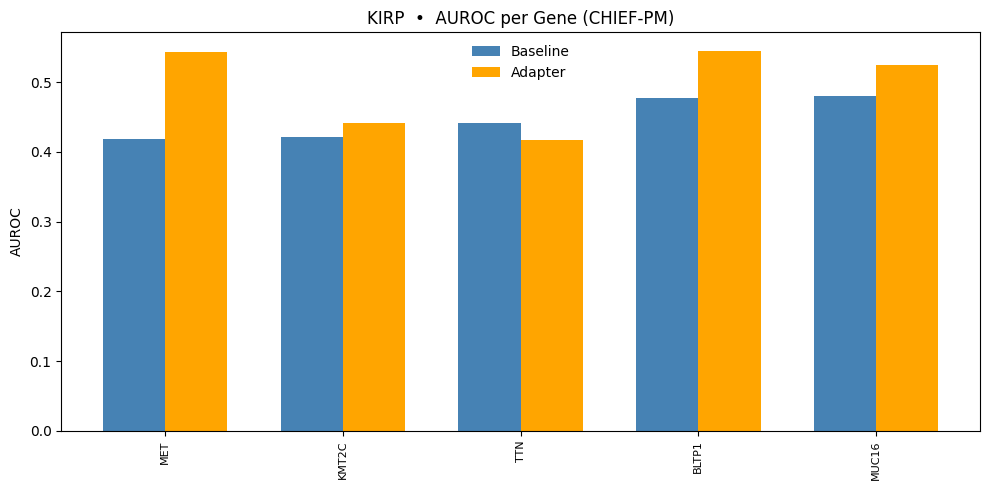

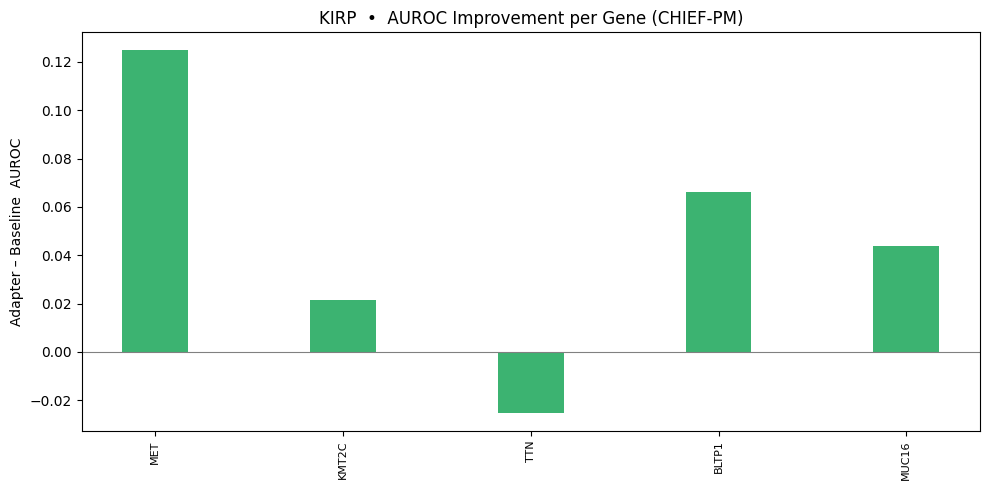

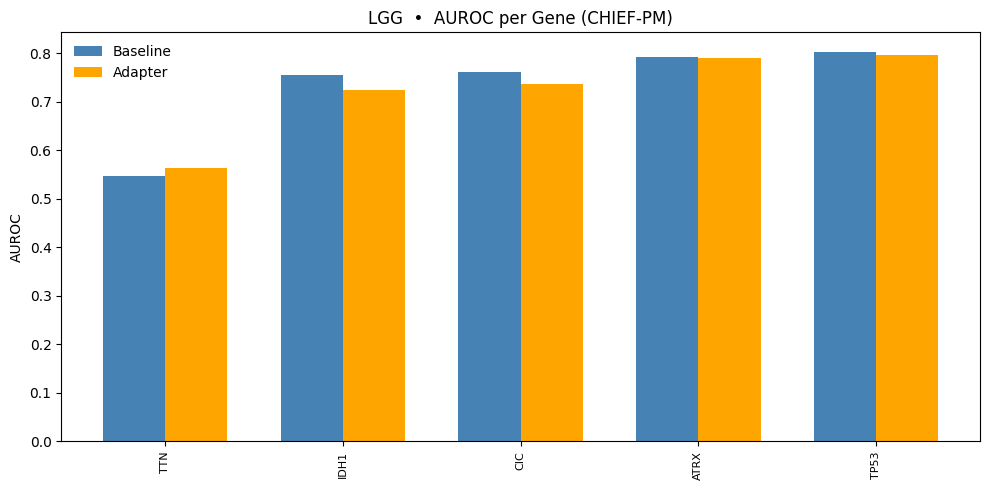

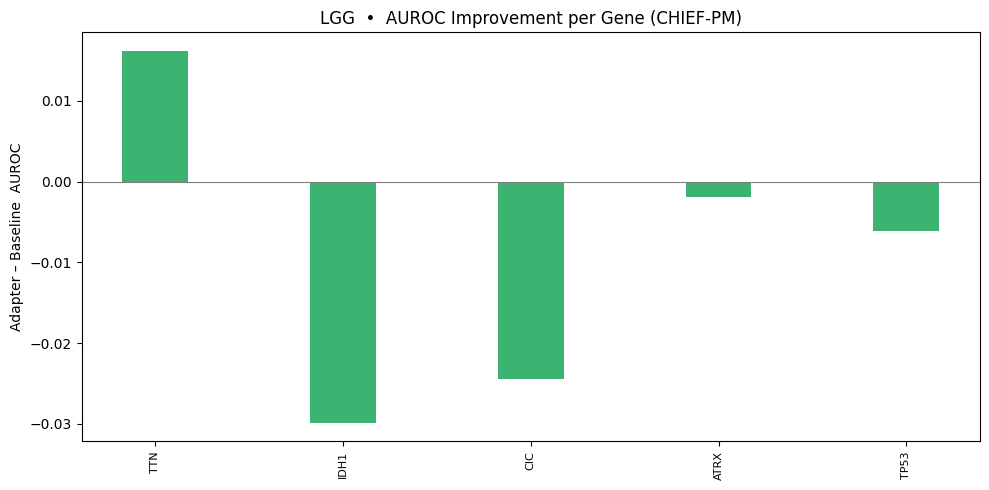

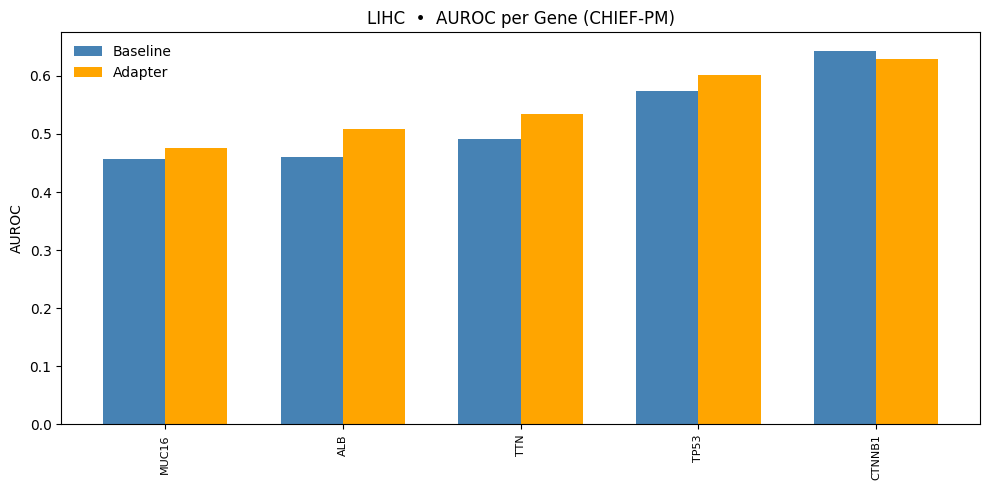

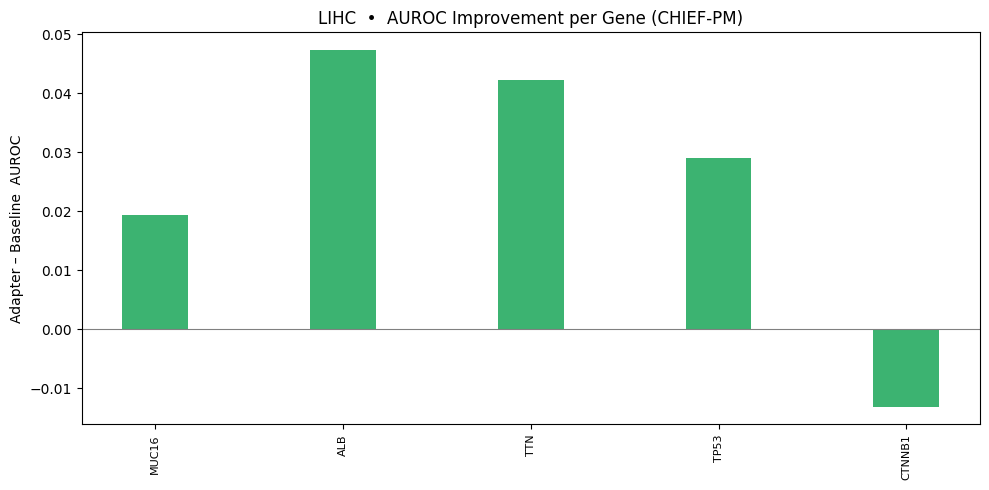

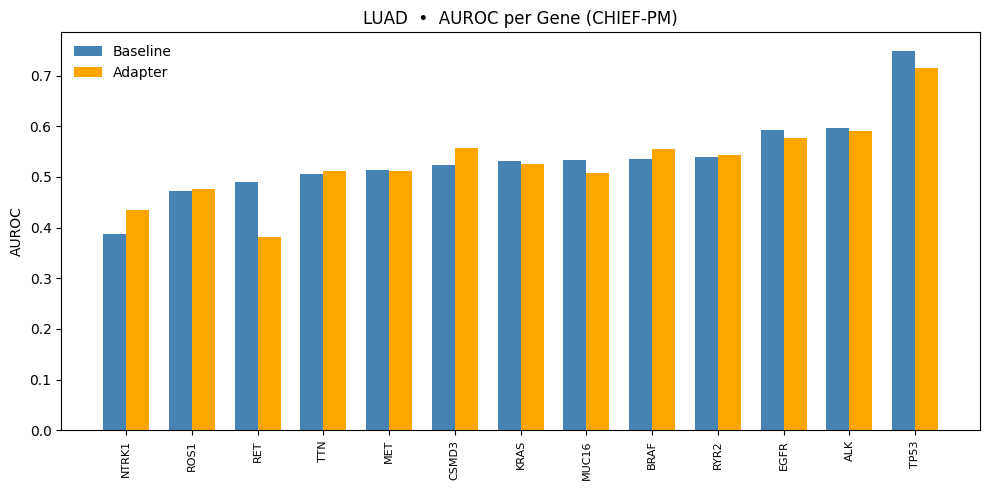

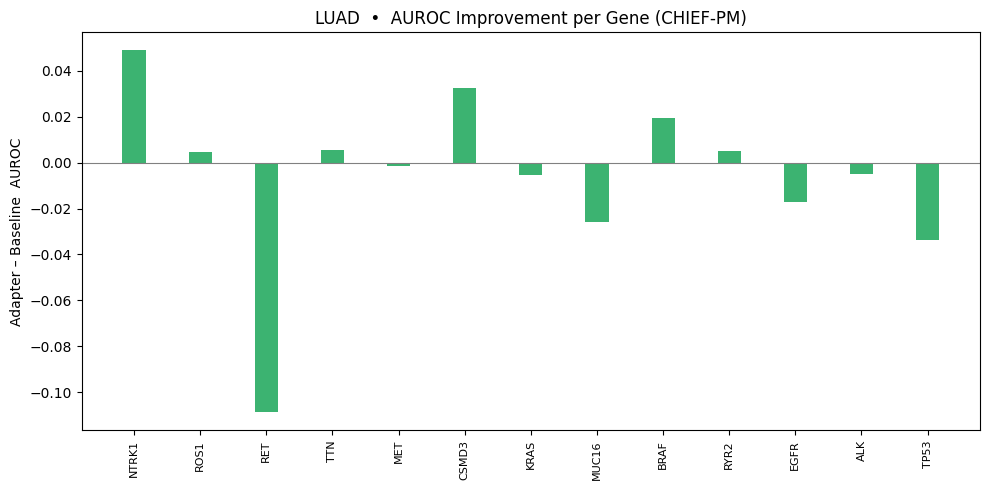

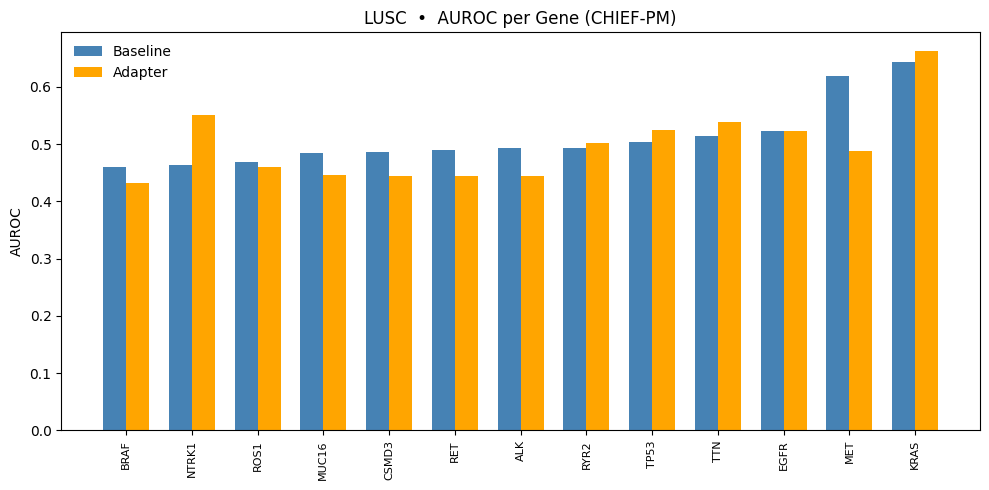

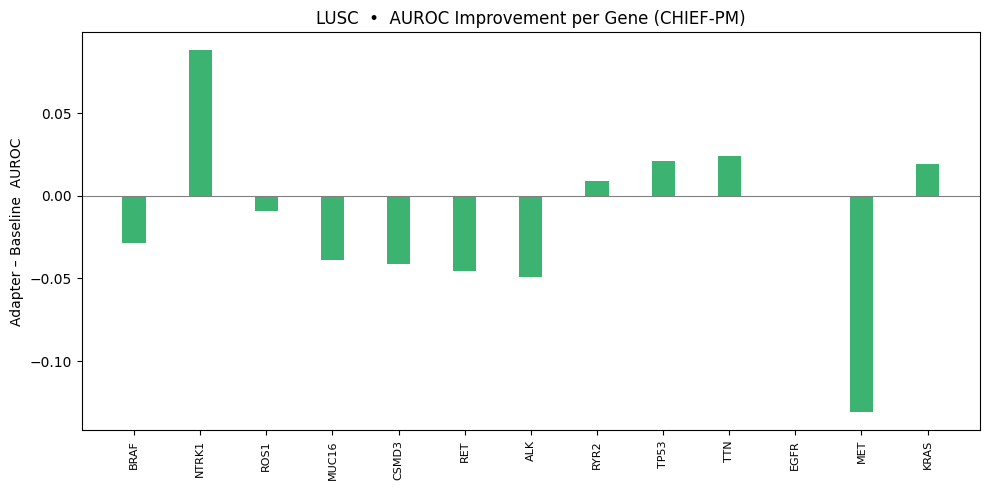

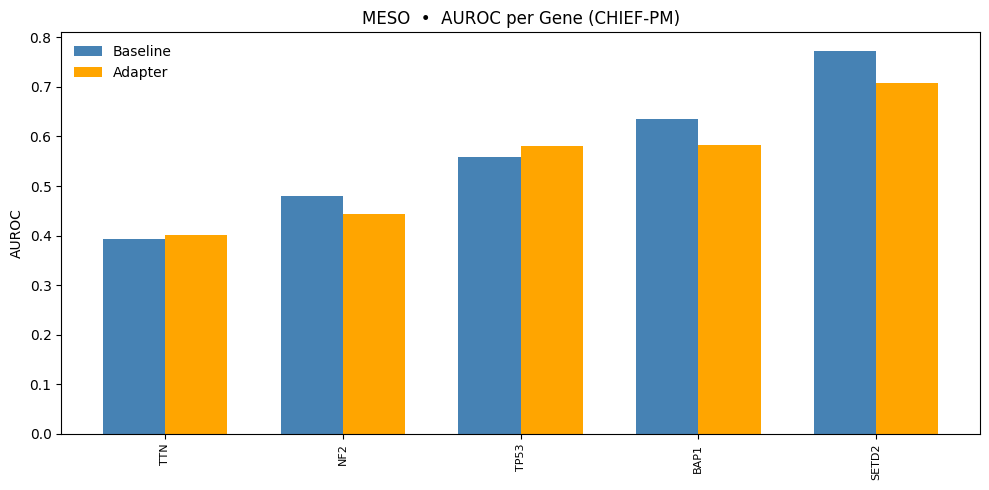

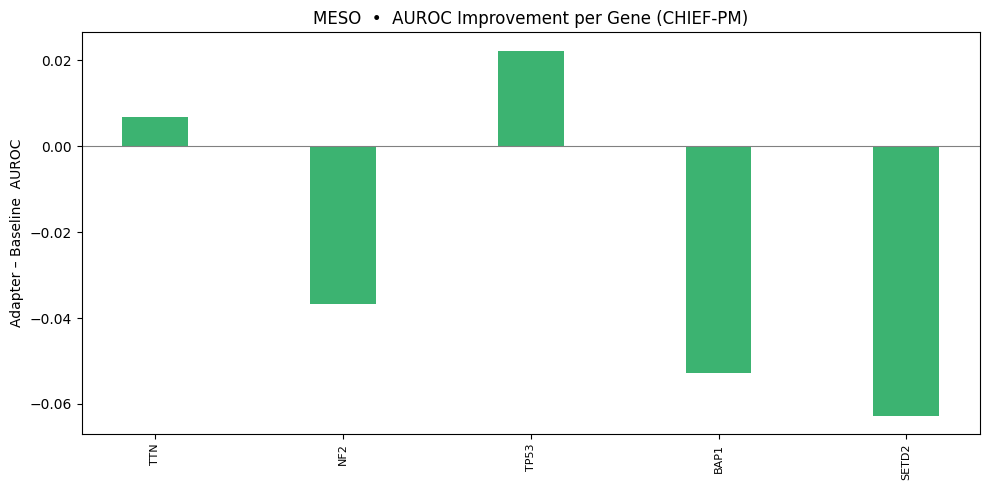

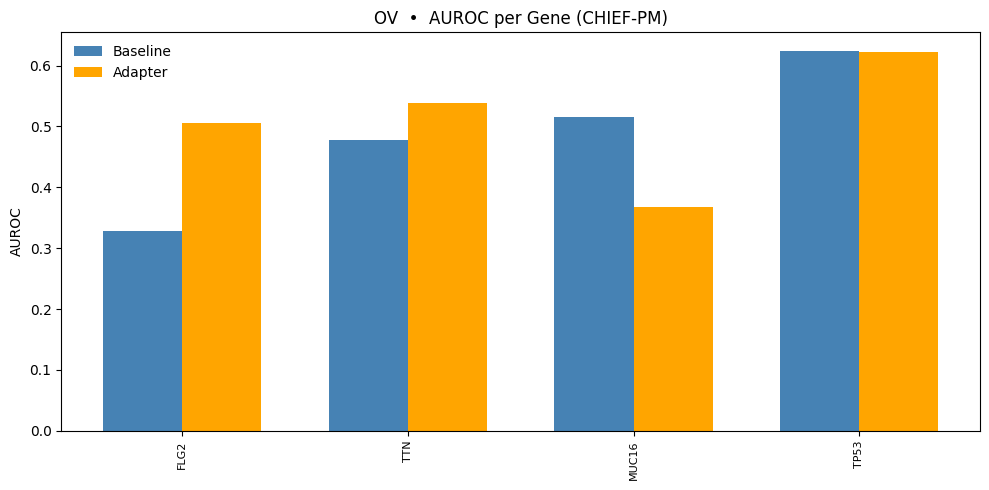

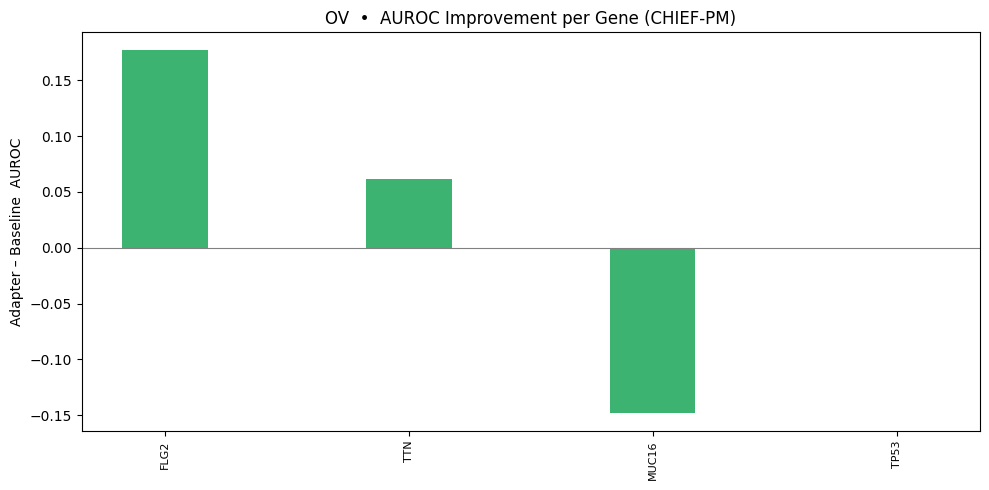

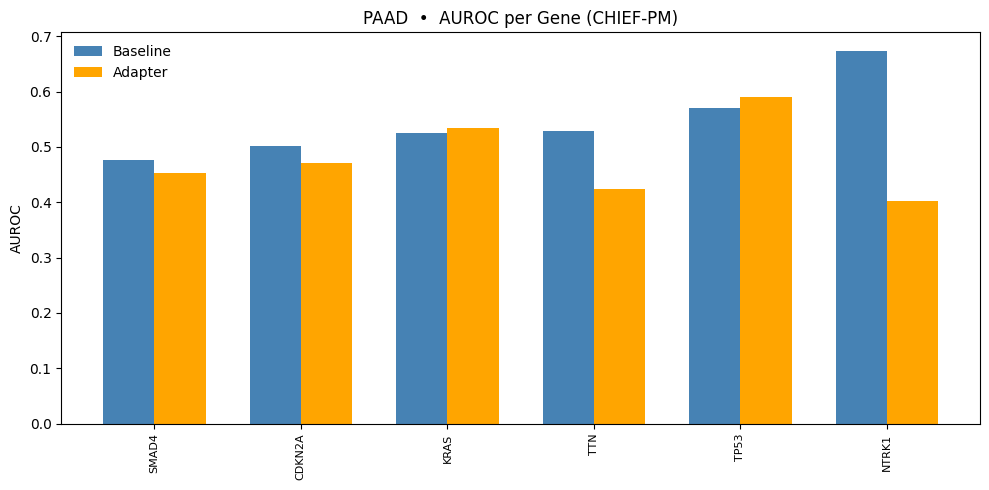

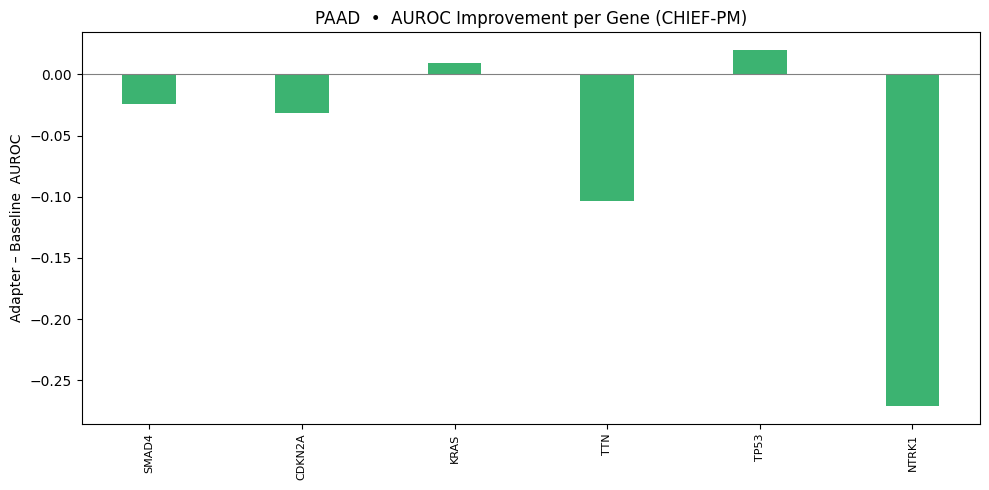

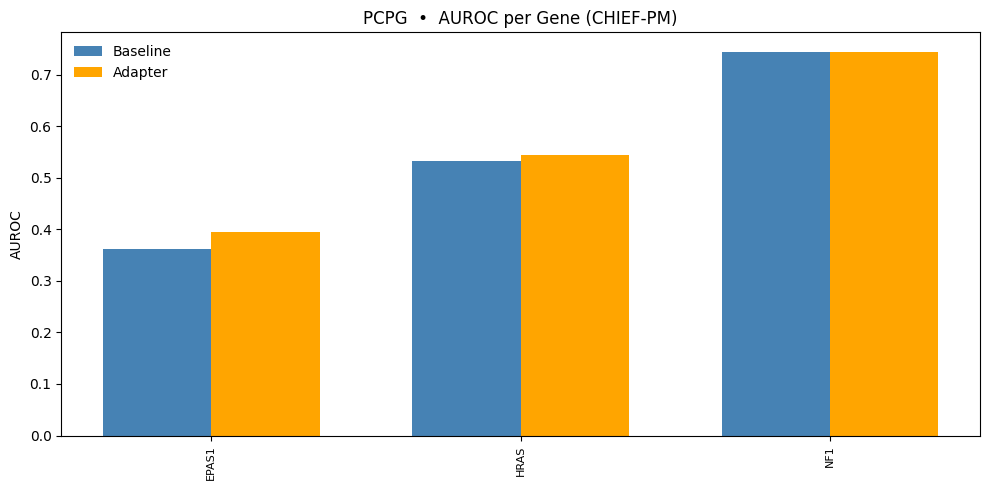

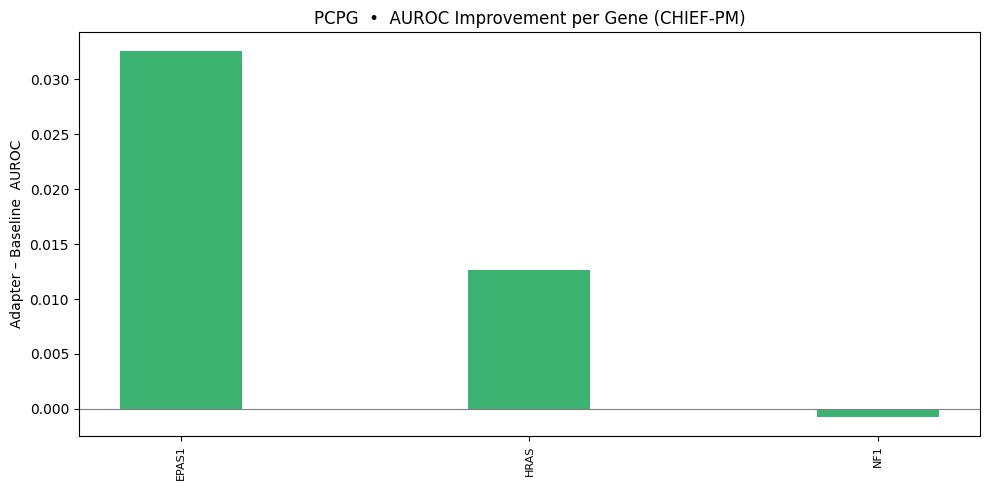

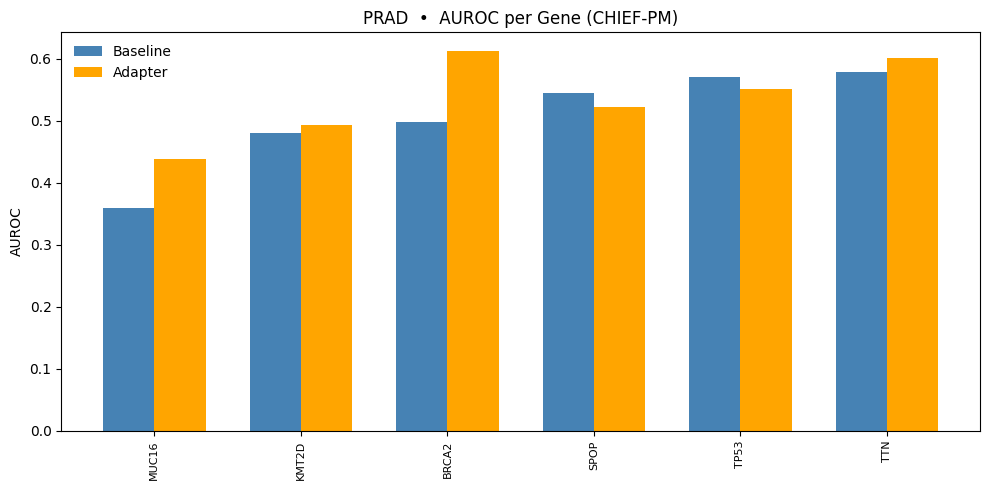

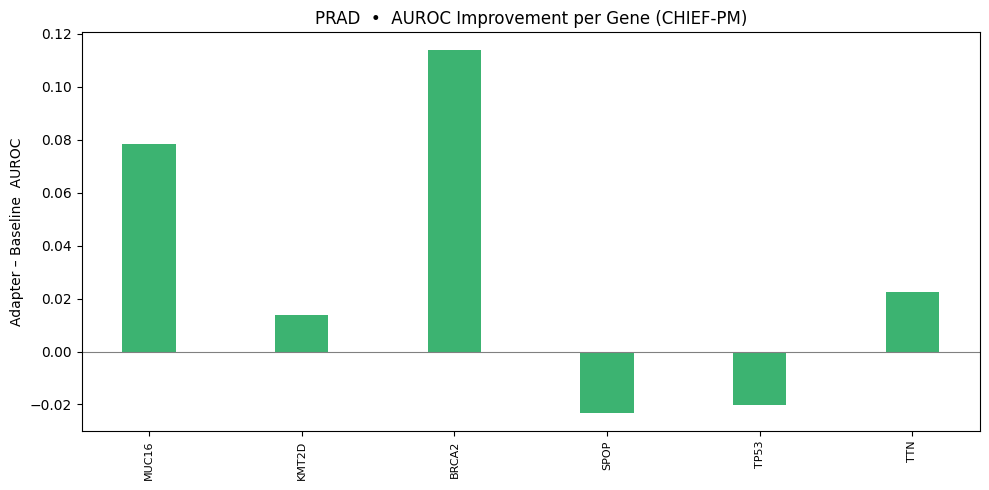

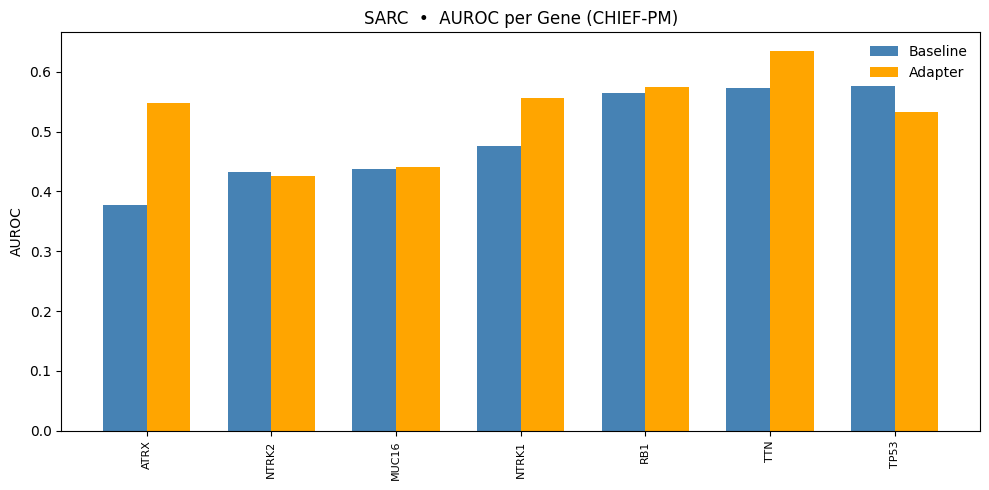

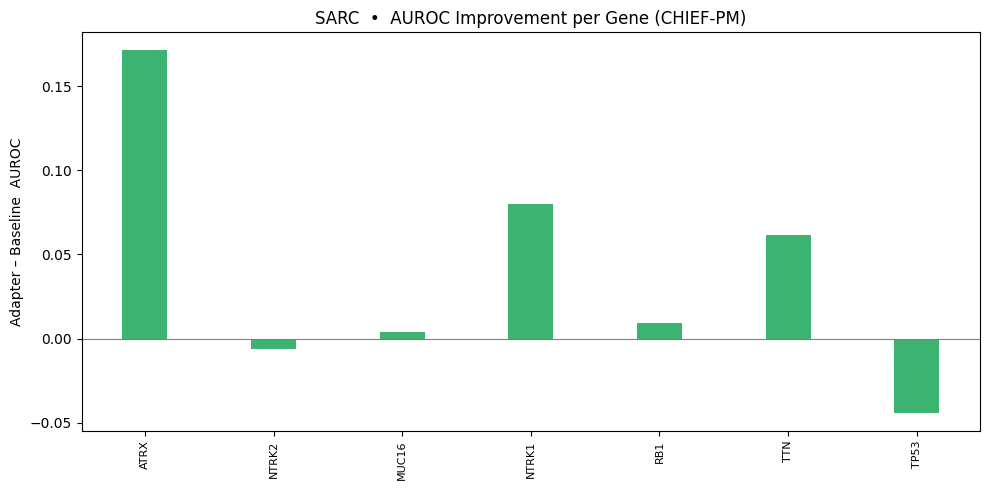

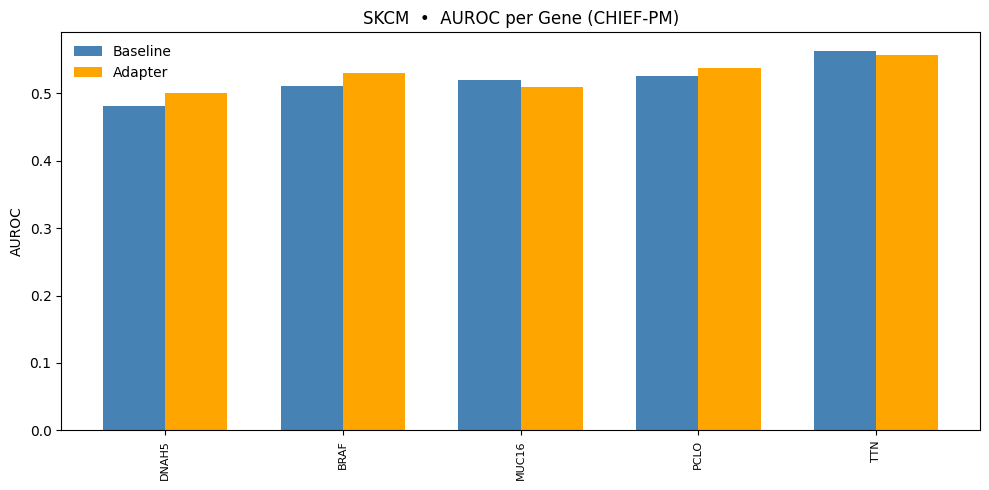

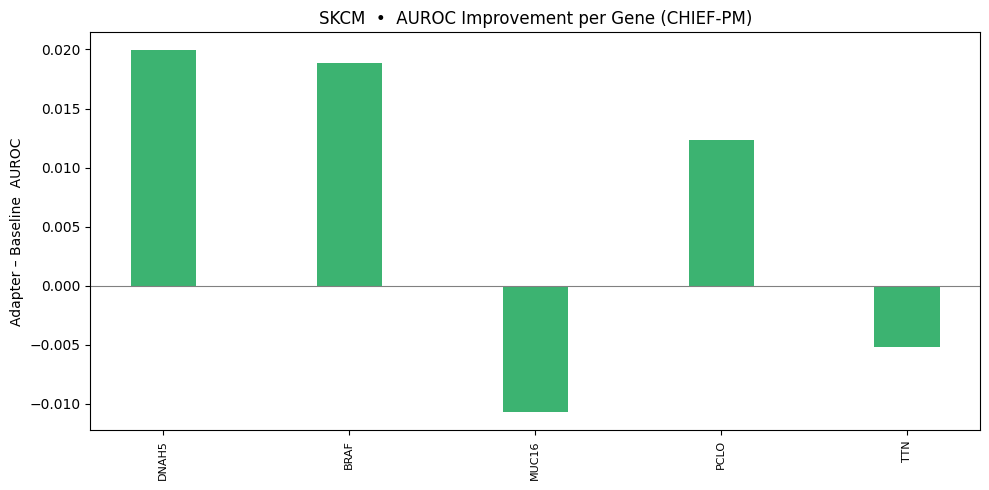

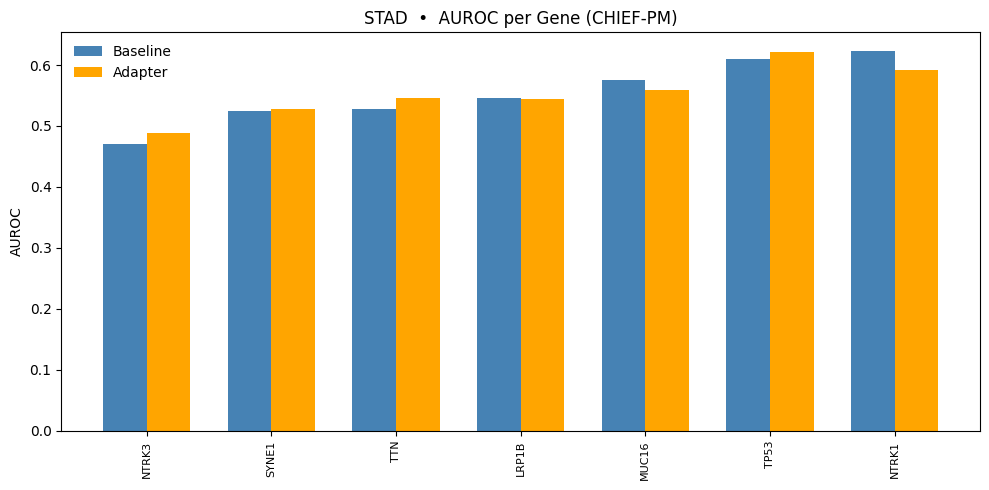

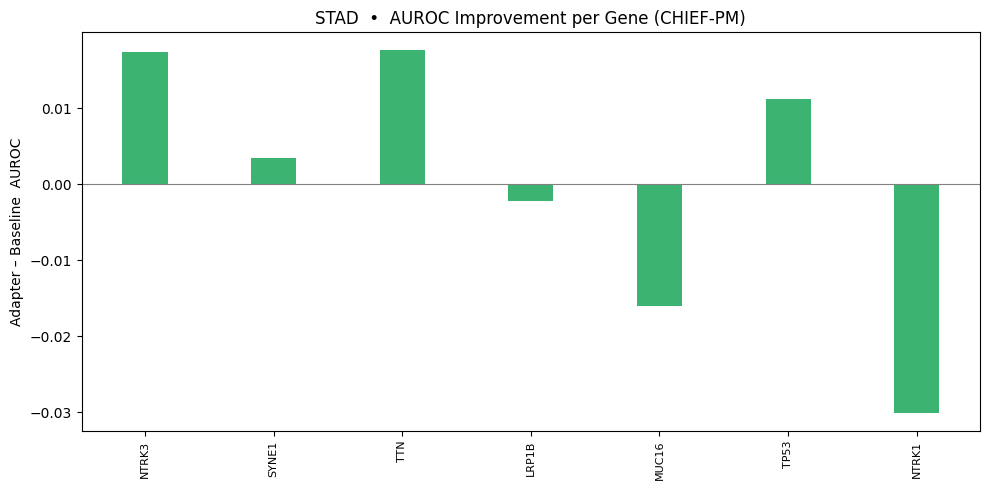

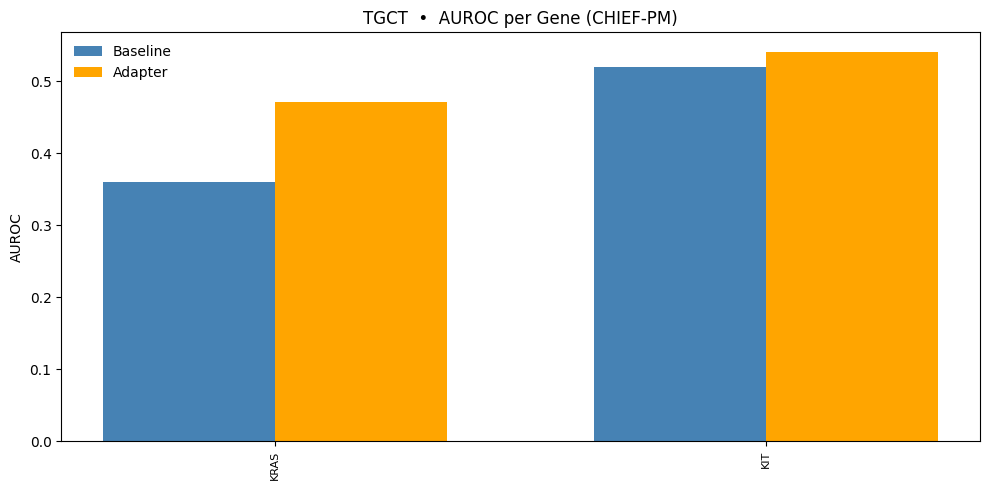

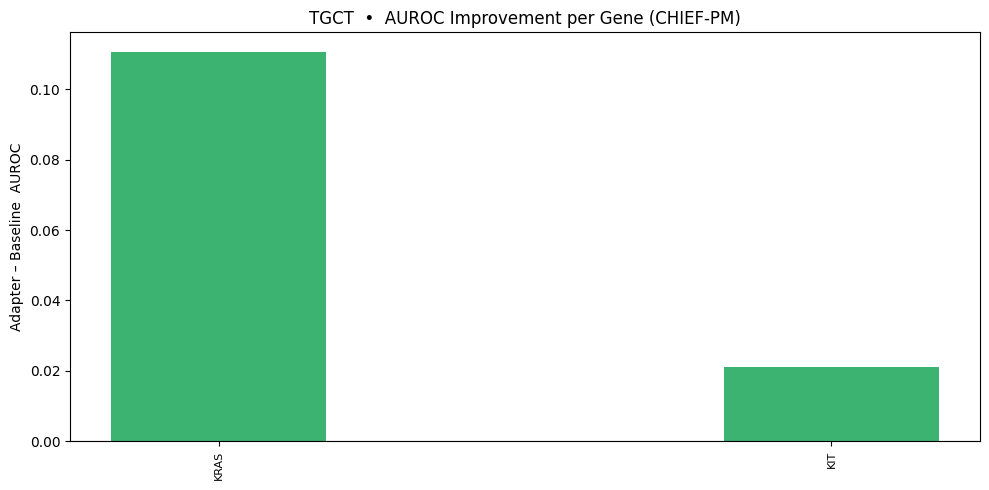

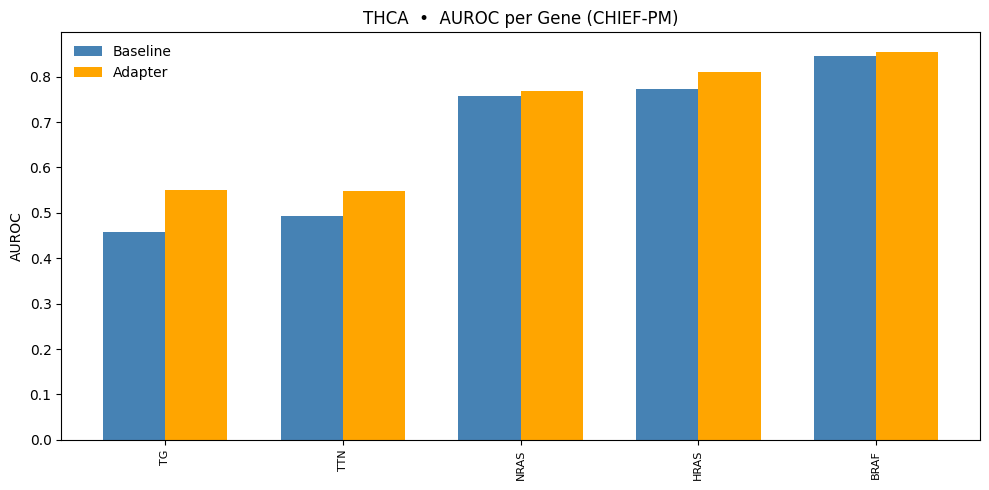

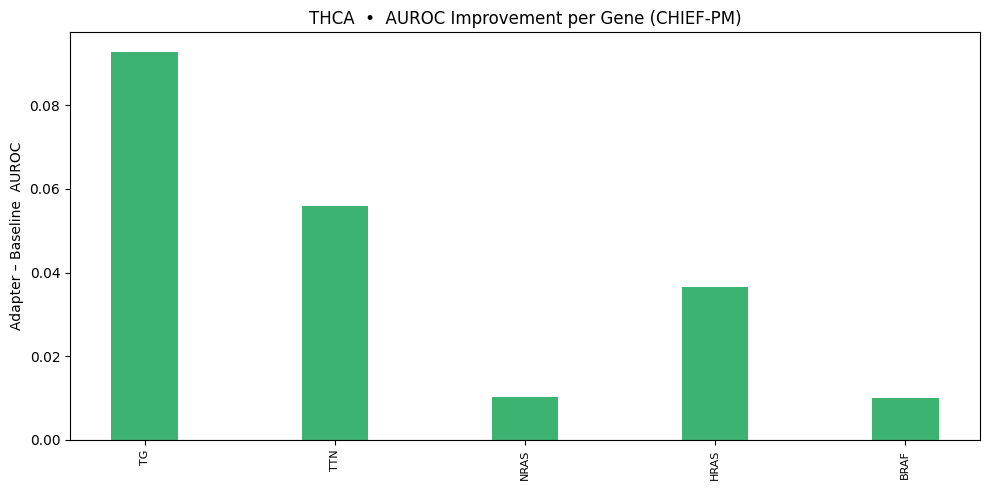

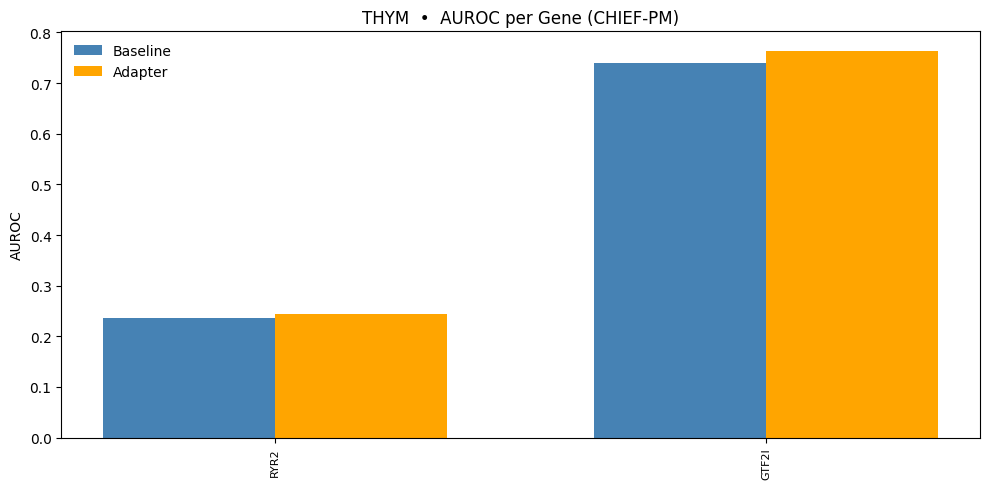

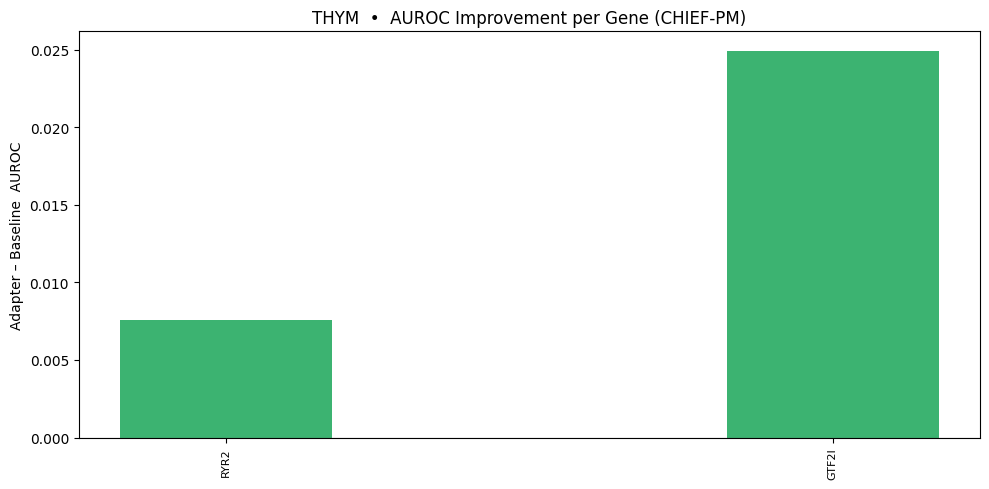

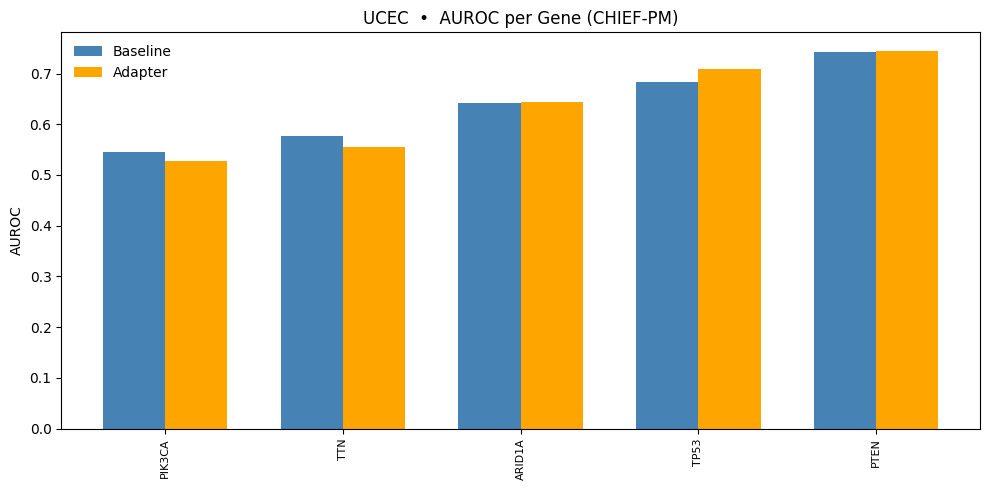

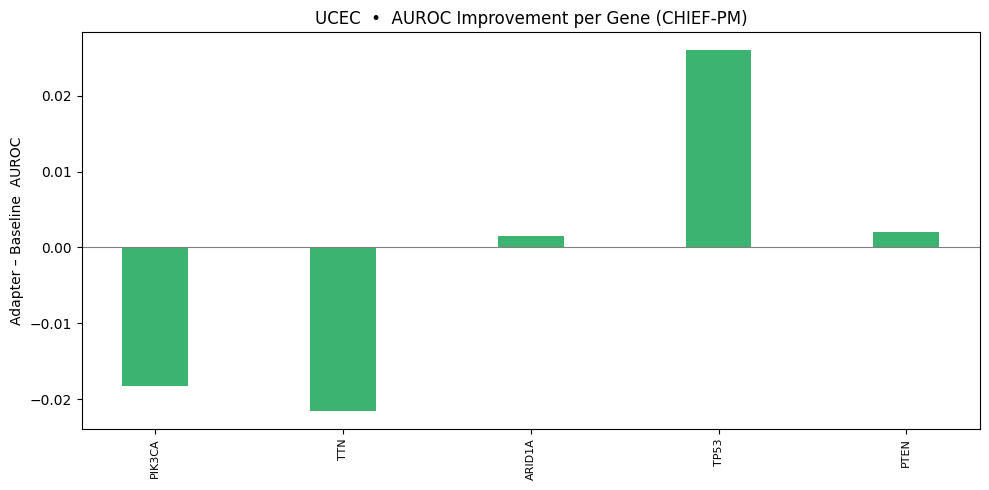

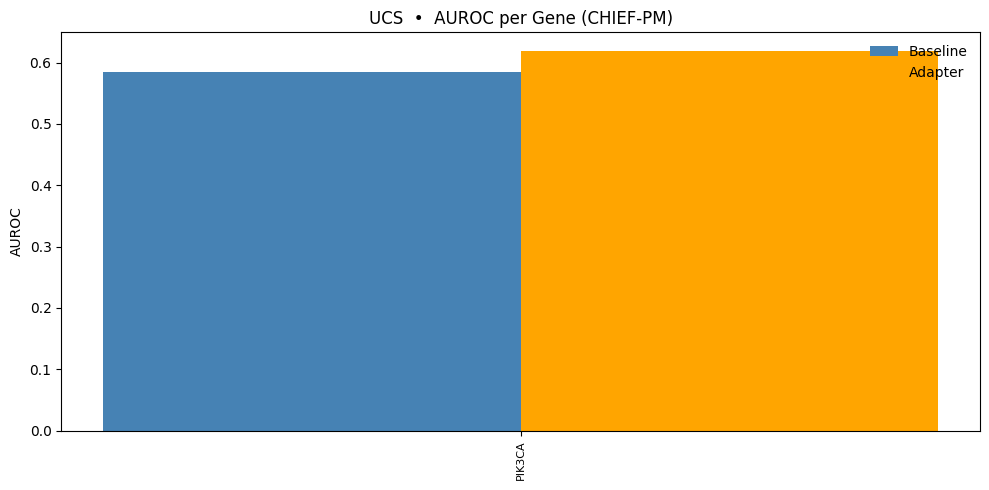

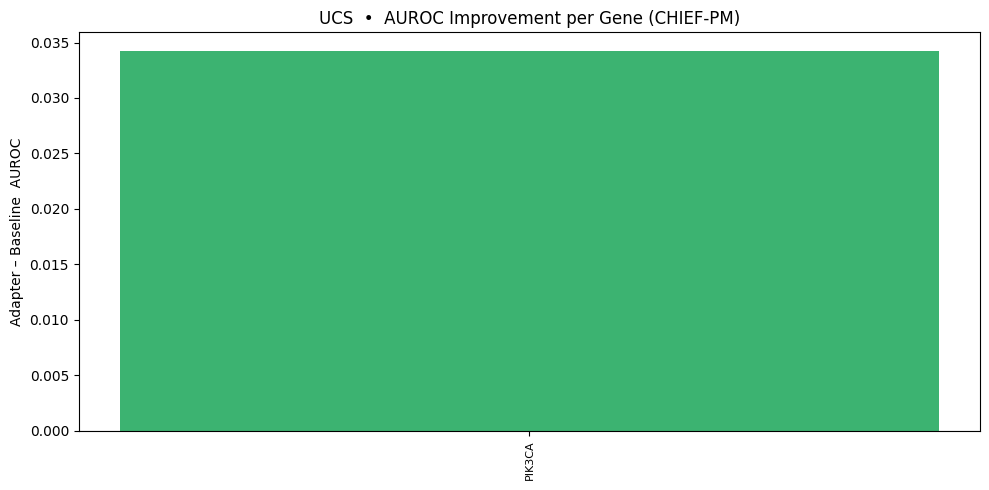

In [80]:
# ============================================================
#  CHIEF-PM  •  per-Cancer bar-plots
#    ➊ AUROC (baseline vs adapter)
#    ➋ AUROC improvement
# ============================================================
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


# ------------------------------------------------------------------
#  plotting helper
# ------------------------------------------------------------------
def plot_cancer(df_c, metric, cancer):
    """
    metric: 'AUROC' or 'Improvement'
    Builds and shows ONE figure for the given cancer.
    """
    genes = df_c['Gene']
    x = np.arange(len(genes))
    bar_w = 0.35

    plt.figure(figsize=(max(10, len(genes)*0.5), 5))
    if metric == 'AUROC':
        plt.bar(x - bar_w/2, df_c['Baseline_AUROC'],
                bar_w, label='Baseline', color='steelblue')
        plt.bar(x + bar_w/2, df_c['Adapter_AUROC'],
                bar_w, label='Adapter',  color='orange')
        plt.ylabel('AUROC')
        plt.legend(frameon=False)
        title = f"{cancer.upper()}  •  AUROC per Gene (CHIEF-PM)"
    else:  # Improvement
        plt.bar(x, df_c['AUROC_Improvement'],
                bar_w, color='mediumseagreen')
        plt.axhline(0, color='gray', lw=0.8)
        plt.ylabel('Adapter – Baseline  AUROC')
        title = f"{cancer.upper()}  •  AUROC Improvement per Gene (CHIEF-PM)"

    plt.xticks(x, genes, rotation=90, fontsize=8)
    plt.title(title)
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------------
#  iterate over cancers (alphabetical order)
# ------------------------------------------------------------------
for cancer in sorted(df['Cancer'].unique()):
    sub = df[df['Cancer'] == cancer].sort_values('Baseline_AUROC')
    if sub.empty:
        continue

    plot_cancer(sub, metric='AUROC',        cancer=cancer)
    plot_cancer(sub, metric='Improvement',  cancer=cancer)


In [43]:
df.to_excel(os.path.join(OUTPUT_PATH,
               f"auroc_comparison_all_cancers_baseline_vs_adapter_all.xlsx"), index=False)

In [41]:
df# Method 1: Using loc to find specific gene
ntrk1_data = df_result_PM.loc[df_result_PM['Gene'] == 'NTRK1']

# Method 2: Using query
ntrk1_data = df_result_PM.query("Gene == 'NTRK1'")

# Print the results
if len(ntrk1_data) > 0:
    print("\nNTRK1 Data:")
    print(ntrk1_data[['Cancer', 'Gene', 'Prevalence', 'Baseline_AUROC', 'Adapter_AUROC']])
else:
    print("NTRK1 not found in the dataset")


NTRK1 Data:
       Cancer   Gene  Prevalence  Baseline_AUROC  Adapter_AUROC
34   coadread  NTRK1    0.021239        0.436257       0.498192
48       esca  NTRK1    0.050955        0.487416       0.513423
61       hnsc  NTRK1         NaN             NaN            NaN
98       luad  NTRK1    0.105590        0.386574       0.435458
111      lusc  NTRK1    0.057851        0.463189       0.551065
127        ov  NTRK1         NaN             NaN            NaN
136      paad  NTRK1    0.052885        0.673281       0.402400
156      sarc  NTRK1    0.074830        0.475560       0.555732
168      stad  NTRK1    0.038071        0.622515       0.592436
196       ucs  NTRK1         NaN             NaN            NaN


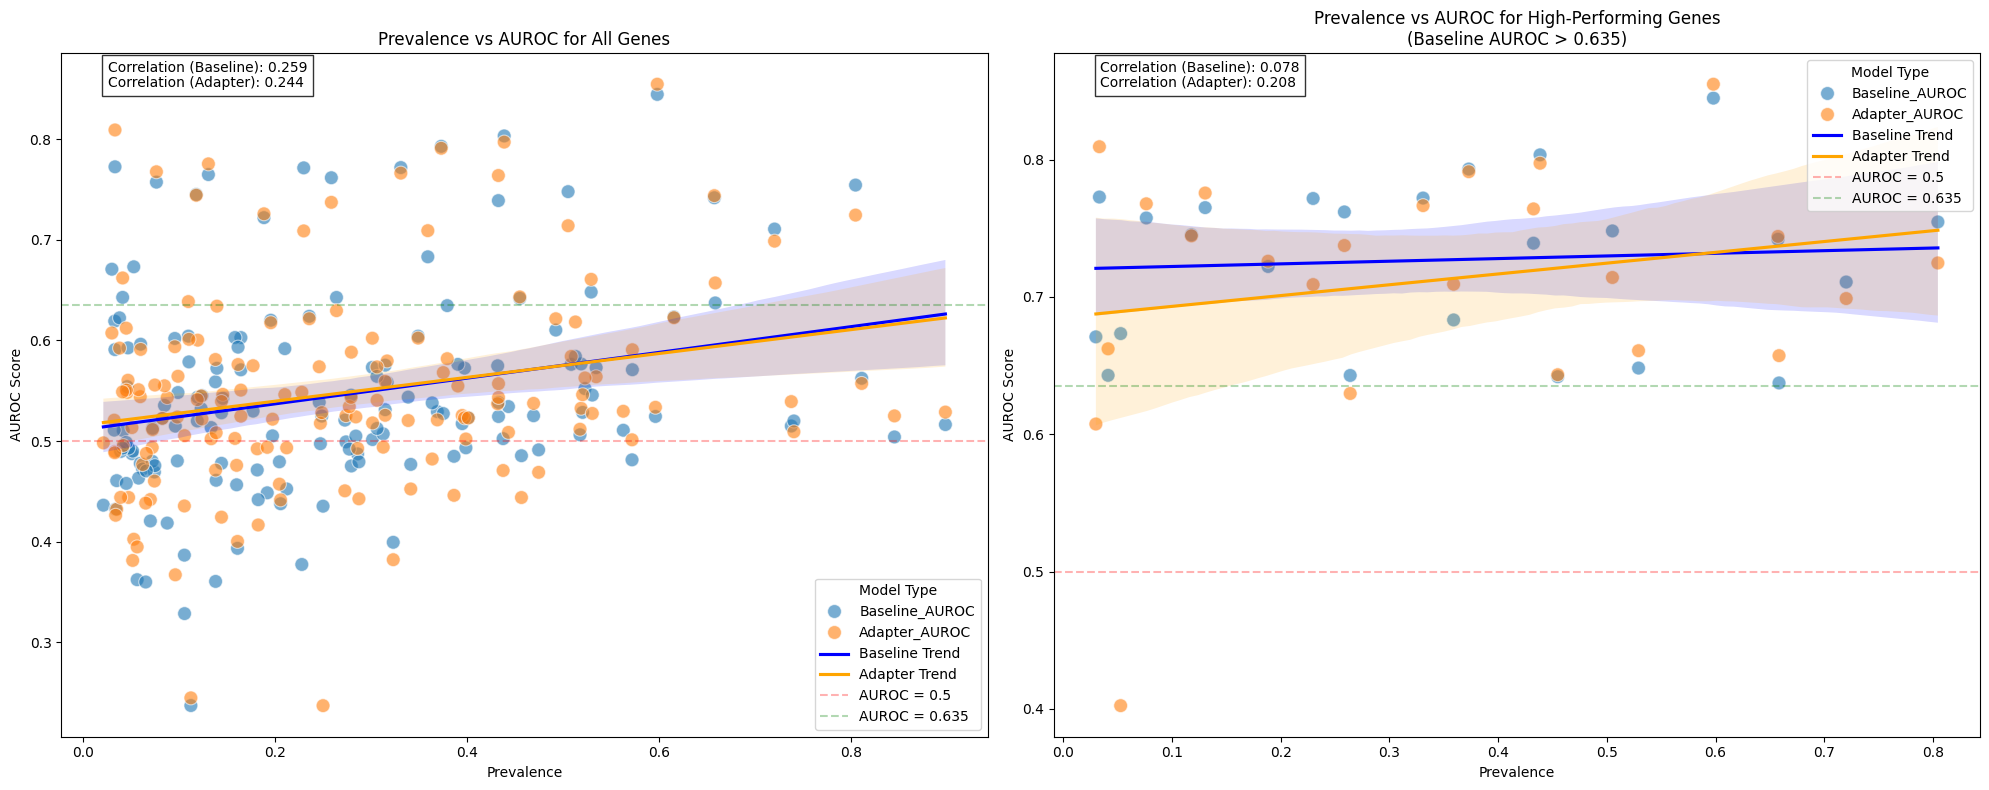


Statistics for All Genes:

Prevalence vs AUROC Correlation:
Baseline: 0.259
Adapter: 0.244

Statistics for High-Performing Genes (Baseline AUROC > 0.635):

Prevalence vs AUROC Correlation:
Baseline: 0.078
Adapter: 0.208

Mean AUROC by Prevalence Quartile (All Genes):
                     Baseline_AUROC  Adapter_AUROC
Prevalence_Quartile                               
Q1                         0.523338       0.521141
Q2                         0.516074       0.533565
Q3                         0.558400       0.550651
Q4                         0.585765       0.586102

Mean AUROC by Prevalence Quartile (High-Performing Genes):
                     Baseline_AUROC  Adapter_AUROC
Prevalence_Quartile                               
Q1                         0.710404       0.665593
Q2                         0.739231       0.724008
Q3                         0.734781       0.736526
Q4                         0.722925       0.723399


In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a long format dataframe for the scatter plot
df_scatter = pd.melt(df_result_PM, 
                     id_vars=['Cancer', 'Gene', 'Prevalence'],
                     value_vars=['Baseline_AUROC', 'Adapter_AUROC'],
                     var_name='Model',
                     value_name='AUROC')

# Filter for high-performing genes
df_high_performing = df_result_PM[df_result_PM['Baseline_AUROC'] > 0.635].copy()
df_scatter_high = pd.melt(df_high_performing, 
                         id_vars=['Cancer', 'Gene', 'Prevalence'],
                         value_vars=['Baseline_AUROC', 'Adapter_AUROC'],
                         var_name='Model',
                         value_name='AUROC')

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot for all genes
sns.scatterplot(data=df_scatter, 
                x='Prevalence', 
                y='AUROC',
                hue='Model',
                alpha=0.6,
                s=100,
                ax=ax1)

# Add regression lines for all genes
sns.regplot(data=df_scatter[df_scatter['Model'] == 'Baseline_AUROC'],
            x='Prevalence',
            y='AUROC',
            scatter=False,
            color='blue',
            label='Baseline Trend',
            ax=ax1)

sns.regplot(data=df_scatter[df_scatter['Model'] == 'Adapter_AUROC'],
            x='Prevalence',
            y='AUROC',
            scatter=False,
            color='orange',
            label='Adapter Trend',
            ax=ax1)

# Add reference lines
ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.3, label='AUROC = 0.5')
ax1.axhline(y=0.635, color='green', linestyle='--', alpha=0.3, label='AUROC = 0.635')

# Customize first plot
ax1.set_title('Prevalence vs AUROC for All Genes')
ax1.set_xlabel('Prevalence')
ax1.set_ylabel('AUROC Score')
ax1.legend(title='Model Type')

# Add correlation coefficients for all genes
corr_baseline = df_result_PM['Prevalence'].corr(df_result_PM['Baseline_AUROC'])
corr_adapter = df_result_PM['Prevalence'].corr(df_result_PM['Adapter_AUROC'])

ax1.text(0.05, 0.95, 
         f'Correlation (Baseline): {corr_baseline:.3f}\nCorrelation (Adapter): {corr_adapter:.3f}',
         transform=ax1.transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

# Plot for high-performing genes
sns.scatterplot(data=df_scatter_high, 
                x='Prevalence', 
                y='AUROC',
                hue='Model',
                alpha=0.6,
                s=100,
                ax=ax2)

# Add regression lines for high-performing genes
sns.regplot(data=df_scatter_high[df_scatter_high['Model'] == 'Baseline_AUROC'],
            x='Prevalence',
            y='AUROC',
            scatter=False,
            color='blue',
            label='Baseline Trend',
            ax=ax2)

sns.regplot(data=df_scatter_high[df_scatter_high['Model'] == 'Adapter_AUROC'],
            x='Prevalence',
            y='AUROC',
            scatter=False,
            color='orange',
            label='Adapter Trend',
            ax=ax2)

# Add reference lines
ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.3, label='AUROC = 0.5')
ax2.axhline(y=0.635, color='green', linestyle='--', alpha=0.3, label='AUROC = 0.635')

# Customize second plot
ax2.set_title('Prevalence vs AUROC for High-Performing Genes\n(Baseline AUROC > 0.635)')
ax2.set_xlabel('Prevalence')
ax2.set_ylabel('AUROC Score')
ax2.legend(title='Model Type')

# Add correlation coefficients for high-performing genes
corr_baseline_high = df_high_performing['Prevalence'].corr(df_high_performing['Baseline_AUROC'])
corr_adapter_high = df_high_performing['Prevalence'].corr(df_high_performing['Adapter_AUROC'])

ax2.text(0.05, 0.95, 
         f'Correlation (Baseline): {corr_baseline_high:.3f}\nCorrelation (Adapter): {corr_adapter_high:.3f}',
         transform=ax2.transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print statistics
print("\nStatistics for All Genes:")
print("\nPrevalence vs AUROC Correlation:")
print(f"Baseline: {corr_baseline:.3f}")
print(f"Adapter: {corr_adapter:.3f}")

print("\nStatistics for High-Performing Genes (Baseline AUROC > 0.635):")
print("\nPrevalence vs AUROC Correlation:")
print(f"Baseline: {corr_baseline_high:.3f}")
print(f"Adapter: {corr_adapter_high:.3f}")

# Print statistics by prevalence quartiles for both groups
print("\nMean AUROC by Prevalence Quartile (All Genes):")
df_result_PM['Prevalence_Quartile'] = pd.qcut(df_result_PM['Prevalence'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
print(df_result_PM.groupby('Prevalence_Quartile')[['Baseline_AUROC', 'Adapter_AUROC']].mean())

print("\nMean AUROC by Prevalence Quartile (High-Performing Genes):")
df_high_performing['Prevalence_Quartile'] = pd.qcut(df_high_performing['Prevalence'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
print(df_high_performing.groupby('Prevalence_Quartile')[['Baseline_AUROC', 'Adapter_AUROC']].mean())

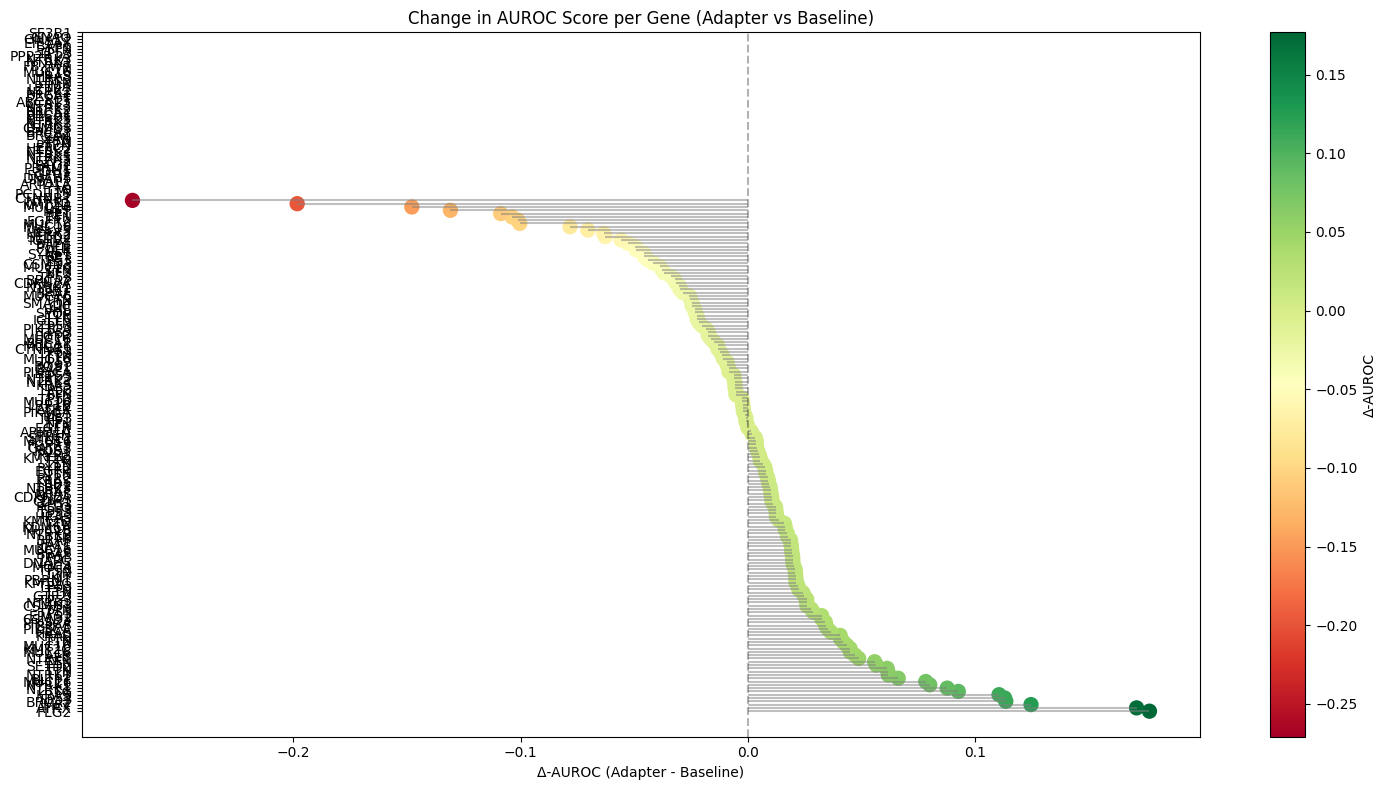

Number of genes with improved AUROC: 87
Number of genes with decreased AUROC: 69
Average Δ-AUROC: 0.002
Maximum improvement: 0.177
Maximum decrease: -0.271


In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate Δ-AUROC (Adapter - Baseline)
df_result_PM['Delta_AUROC'] = df_result_PM['Adapter_AUROC'] - df_result_PM['Baseline_AUROC']

# Sort by Δ-AUROC for better visualizationeeee_sorted = df_result_PM.sort_values('Delta_AUROC', ascending=False)

# Create the figure
plt.figure(figsize=(15, 8))

# Create the lollipop plot
plt.hlines(y=range(len(df_sorted)), xmin=0, xmax=df_sorted['Delta_AUROC'], 
           color='gray', alpha=0.5)
plt.scatter(df_sorted['Delta_AUROC'], range(len(df_sorted)), 
           c=df_sorted['Delta_AUROC'], cmap='RdYlGn', s=100)

# Add a vertical line at 0
plt.axvline(x=0, color='black', linestyle='--', alpha=0.3)

# Customize the plot
plt.yticks(range(len(df_sorted)), df_sorted['Gene'])
plt.xlabel('Δ-AUROC (Adapter - Baseline)')
plt.title('Change in AUROC Score per Gene (Adapter vs Baseline)')

# Add colorbar
plt.colorbar(label='Δ-AUROC')

# Adjust layout
plt.tight_layout()
plt.show()

# Print some statistics
print(f"Number of genes with improved AUROC: {sum(df_result_PM['Delta_AUROC'] > 0)}")
print(f"Number of genes with decreased AUROC: {sum(df_result_PM['Delta_AUROC'] < 0)}")
print(f"Average Δ-AUROC: {df_result_PM['Delta_AUROC'].mean():.3f}")
print(f"Maximum improvement: {df_result_PM['Delta_AUROC'].max():.3f}")
print(f"Maximum decrease: {df_result_PM['Delta_AUROC'].min():.3f}")

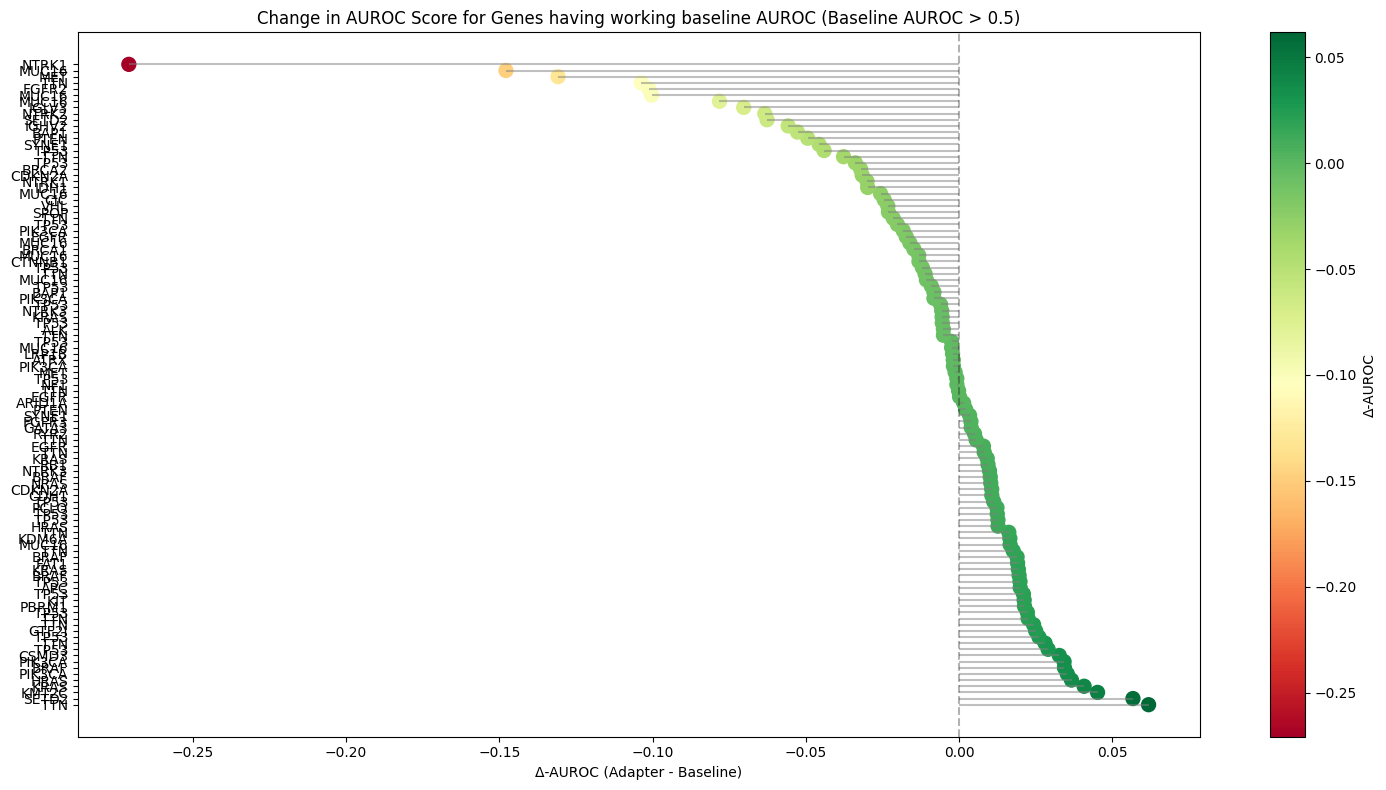

Number of high-performing genes: 105
Number of genes with improved AUROC: 51
Number of genes with decreased AUROC: 54
Average Δ-AUROC: -0.009
Maximum improvement: 0.062
Maximum decrease: -0.271

High-performing genes and their baseline AUROC values:
TTN: Baseline AUROC = 0.572
SETD2: Baseline AUROC = 0.544
KMT2C: Baseline AUROC = 0.530
KRAS: Baseline AUROC = 0.527
HRAS: Baseline AUROC = 0.773
PIK3CA: Baseline AUROC = 0.539
BRAF: Baseline AUROC = 0.604
PIK3CA: Baseline AUROC = 0.584
CSMD3: Baseline AUROC = 0.524
TP53: Baseline AUROC = 0.573
TTN: Baseline AUROC = 0.513
TP53: Baseline AUROC = 0.683
GTF2I: Baseline AUROC = 0.739
TTN: Baseline AUROC = 0.515
TTN: Baseline AUROC = 0.579
TP53: Baseline AUROC = 0.559
PBRM1: Baseline AUROC = 0.558
KIT: Baseline AUROC = 0.520
TP53: Baseline AUROC = 0.504
APC: Baseline AUROC = 0.637
TP53: Baseline AUROC = 0.571
BRAF: Baseline AUROC = 0.535
KRAS: Baseline AUROC = 0.643
FAT1: Baseline AUROC = 0.505
BRAF: Baseline AUROC = 0.511
TTN: Baseline AUROC = 

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Filter for genes with baseline AUROC > 0.635
df_high_performing = df_result_PM[df_result_PM['Baseline_AUROC'] > 0.5].copy()

# Calculate Δ-AUROC (Adapter - Baseline)
df_high_performing['Delta_AUROC'] = df_high_performing['Adapter_AUROC'] - df_high_performing['Baseline_AUROC']

# Sort by Δ-AUROC for better visualization
df_sorted = df_high_performing.sort_values('Delta_AUROC', ascending=False)

# Create the figure
plt.figure(figsize=(15, 8))

# Create the lollipop plot
plt.hlines(y=range(len(df_sorted)), xmin=0, xmax=df_sorted['Delta_AUROC'], 
           color='gray', alpha=0.5)
plt.scatter(df_sorted['Delta_AUROC'], range(len(df_sorted)), 
           c=df_sorted['Delta_AUROC'], cmap='RdYlGn', s=100)

# Add a vertical line at 0
plt.axvline(x=0, color='black', linestyle='--', alpha=0.3)

# Customize the plot
plt.yticks(range(len(df_sorted)), df_sorted['Gene'])
plt.xlabel('Δ-AUROC (Adapter - Baseline)')
plt.title('Change in AUROC Score for Genes having working baseline AUROC (Baseline AUROC > 0.5)')

# Add colorbar
plt.colorbar(label='Δ-AUROC')

# Adjust layout
plt.tight_layout()
plt.show()

# Print some statistics
print(f"Number of high-performing genes: {len(df_high_performing)}")
print(f"Number of genes with improved AUROC: {sum(df_high_performing['Delta_AUROC'] > 0)}")
print(f"Number of genes with decreased AUROC: {sum(df_high_performing['Delta_AUROC'] < 0)}")
print(f"Average Δ-AUROC: {df_high_performing['Delta_AUROC'].mean():.3f}")
print(f"Maximum improvement: {df_high_performing['Delta_AUROC'].max():.3f}")
print(f"Maximum decrease: {df_high_performing['Delta_AUROC'].min():.3f}")

# Print the genes and their baseline AUROC values
print("\nHigh-performing genes and their baseline AUROC values:")
for _, row in df_sorted.iterrows():
    print(f"{row['Gene']}: Baseline AUROC = {row['Baseline_AUROC']:.3f}")

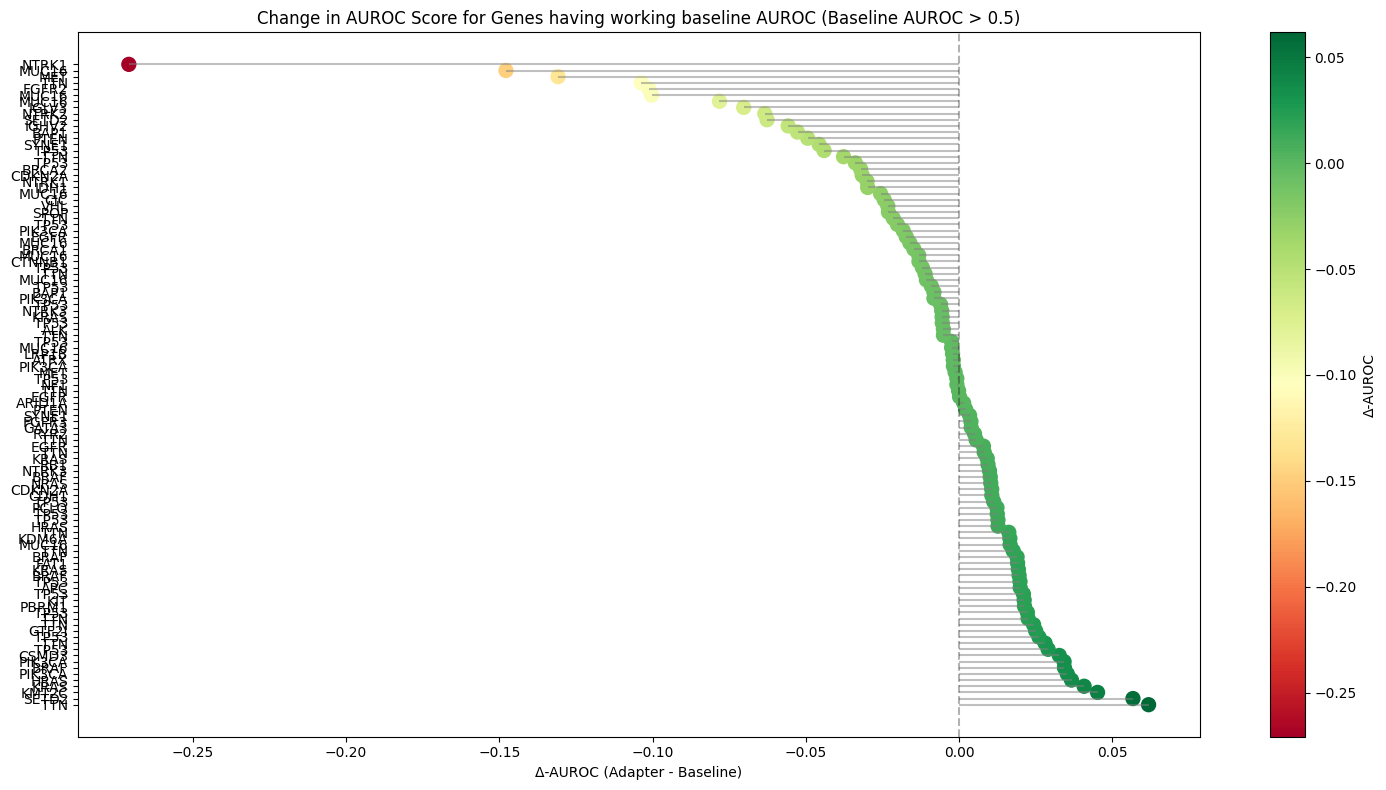

Number of high-performing genes: 105
Number of genes with improved AUROC: 51
Number of genes with decreased AUROC: 54
Average Δ-AUROC: -0.009
Maximum improvement: 0.062
Maximum decrease: -0.271

Top 10 improvements in AUROC:
Cancer - Gene | Baseline AUROC | Adapter AUROC | Δ-AUROC
------------------------------------------------------------
sarc - TTN | 0.572 | 0.634 | 0.062
kirc - SETD2 | 0.544 | 0.600 | 0.057
cesc - KMT2C | 0.530 | 0.575 | 0.045
coadread - KRAS | 0.527 | 0.568 | 0.041
thca - HRAS | 0.773 | 0.809 | 0.037
coadread - PIK3CA | 0.539 | 0.574 | 0.035
coadread - BRAF | 0.604 | 0.639 | 0.034
ucs - PIK3CA | 0.584 | 0.618 | 0.034
luad - CSMD3 | 0.524 | 0.557 | 0.033
lihc - TP53 | 0.573 | 0.602 | 0.029


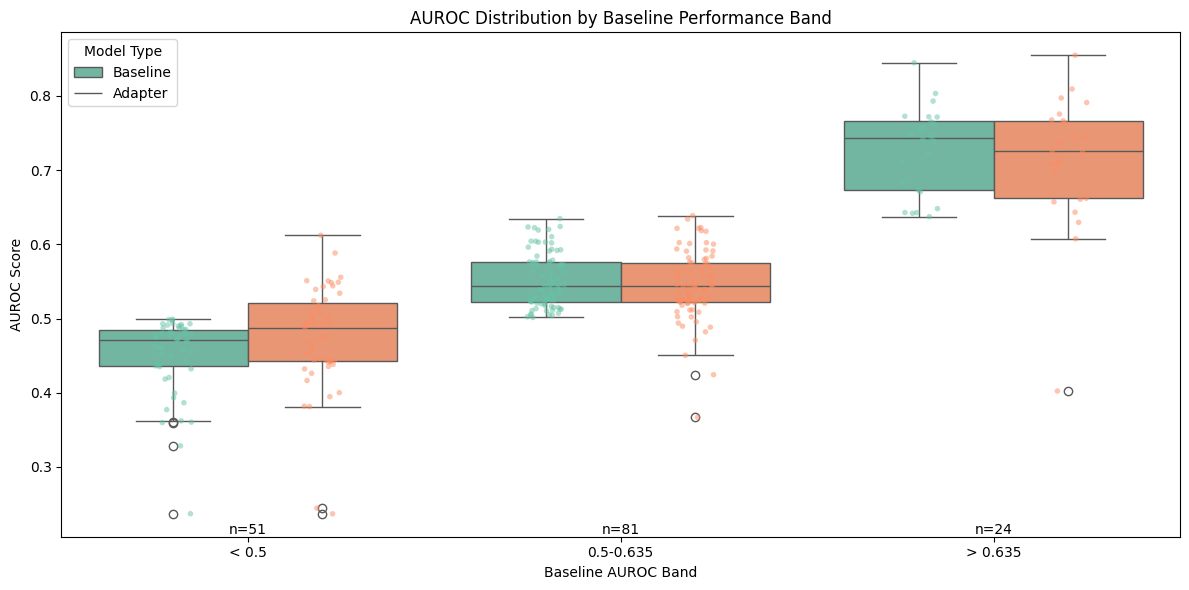


Statistics by AUROC Band:

< 0.5 Band:
Number of genes: 51
Mean AUROC:
  Baseline: 0.451
  Adapter: 0.475
  Mean Δ-AUROC: 0.024

0.5-0.635 Band:
Number of genes: 81
Mean AUROC:
  Baseline: 0.552
  Adapter: 0.545
  Mean Δ-AUROC: -0.007

> 0.635 Band:
Number of genes: 24
Mean AUROC:
  Baseline: 0.727
  Adapter: 0.712
  Mean Δ-AUROC: -0.014


In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Filter for genes with baseline AUROC > 0.5
df_high_performing = df_result_PM[df_result_PM['Baseline_AUROC'] > 0.5].copy()

# Calculate Δ-AUROC (Adapter - Baseline)
df_high_performing['Delta_AUROC'] = df_high_performing['Adapter_AUROC'] - df_high_performing['Baseline_AUROC']

# Sort by Δ-AUROC for better visualization
df_sorted = df_high_performing.sort_values('Delta_AUROC', ascending=False)

# Create the figure
plt.figure(figsize=(15, 8))

# Create the lollipop plot
plt.hlines(y=range(len(df_sorted)), xmin=0, xmax=df_sorted['Delta_AUROC'], 
           color='gray', alpha=0.5)
plt.scatter(df_sorted['Delta_AUROC'], range(len(df_sorted)), 
           c=df_sorted['Delta_AUROC'], cmap='RdYlGn', s=100)

# Add a vertical line at 0
plt.axvline(x=0, color='black', linestyle='--', alpha=0.3)

# Customize the plot
plt.yticks(range(len(df_sorted)), df_sorted['Gene'])
plt.xlabel('Δ-AUROC (Adapter - Baseline)')
plt.title('Change in AUROC Score for Genes having working baseline AUROC (Baseline AUROC > 0.5)')

# Add colorbar
plt.colorbar(label='Δ-AUROC')

# Adjust layout
plt.tight_layout()
plt.show()

# Print statistics
print(f"Number of high-performing genes: {len(df_high_performing)}")
print(f"Number of genes with improved AUROC: {sum(df_high_performing['Delta_AUROC'] > 0)}")
print(f"Number of genes with decreased AUROC: {sum(df_high_performing['Delta_AUROC'] < 0)}")
print(f"Average Δ-AUROC: {df_high_performing['Delta_AUROC'].mean():.3f}")
print(f"Maximum improvement: {df_high_performing['Delta_AUROC'].max():.3f}")
print(f"Maximum decrease: {df_high_performing['Delta_AUROC'].min():.3f}")

# Print top 10 improvements
print("\nTop 10 improvements in AUROC:")
print("Cancer - Gene | Baseline AUROC | Adapter AUROC | Δ-AUROC")
print("-" * 60)
for _, row in df_sorted.head(10).iterrows():
    print(f"{row['Cancer']} - {row['Gene']} | {row['Baseline_AUROC']:.3f} | {row['Adapter_AUROC']:.3f} | {row['Delta_AUROC']:.3f}")

# Create visualization for different AUROC bands
# First, create the bands
df_result_PM['AUROC_Band'] = pd.cut(df_result_PM['Baseline_AUROC'], 
                                   bins=[-np.inf, 0.5, 0.635, np.inf],
                                   labels=['< 0.5', '0.5-0.635', '> 0.635'])

# Create a long format dataframe for the comparison
df_bands = pd.melt(df_result_PM, 
                   id_vars=['Cancer', 'Gene', 'AUROC_Band'],
                   value_vars=['Baseline_AUROC', 'Adapter_AUROC'],
                   var_name='Model',
                   value_name='AUROC')

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_bands, 
            x='AUROC_Band', 
            y='AUROC',
            hue='Model',
            palette='Set2')

# Add individual points
sns.stripplot(data=df_bands, 
              x='AUROC_Band', 
              y='AUROC',
              hue='Model',
              dodge=True,
              palette='Set2',
              alpha=0.5,
              size=4)

plt.title('AUROC Distribution by Baseline Performance Band')
plt.xlabel('Baseline AUROC Band')
plt.ylabel('AUROC Score')
plt.legend(title='Model Type', 
          labels=['Baseline', 'Adapter'])

# Add count annotations
for i, band in enumerate(['< 0.5', '0.5-0.635', '> 0.635']):
    count = len(df_result_PM[df_result_PM['AUROC_Band'] == band])
    plt.text(i, plt.ylim()[0], f'n={count}', 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print statistics for each band
print("\nStatistics by AUROC Band:")
for band in ['< 0.5', '0.5-0.635', '> 0.635']:
    print(f"\n{band} Band:")
    band_data = df_result_PM[df_result_PM['AUROC_Band'] == band]
    print(f"Number of genes: {len(band_data)}")
    print("Mean AUROC:")
    print(f"  Baseline: {band_data['Baseline_AUROC'].mean():.3f}")
    print(f"  Adapter: {band_data['Adapter_AUROC'].mean():.3f}")
    print(f"  Mean Δ-AUROC: {(band_data['Adapter_AUROC'] - band_data['Baseline_AUROC']).mean():.3f}")

## Pretrained??

In [ ]:
import pandas as pd

# Use pd.read_excel for .xlsx files
df1 = pd.read_excel('/home/chp6257/PEFT/QALY-Tuning/progress-summary-qaly/fff.xlsx')
df2 = pd.read_excel('/home/chp6257/PEFT/QALY-Tuning/progress-summary-qaly/auroc_comparison_all_cancers_pretrained_or_not.xlsx')

# Merge on the common columns "Cancer" and "Gene"
merged_df = pd.merge(df1, df2, on=['Cancer', 'Gene'], how='outer')
a
# Save the merged table if needed
merged_df.to_excel('/home/chp6257/PEFT/QALY-Tuning/progress-summary-qaly/merged_compared_aurocs.xlsx', index=False)
print("Merged table saved as merged_aurocs.xlsx")


Merged table saved as merged_aurocs.xlsx


In [ ]:
merged_df

In [48]:
import pandas as pd

# Assume df is already loaded, e.g., from an Excel file:
# df = pd.read_excel('merged_compared_aurocs.xlsx')

# Calculate improvements over baseline AUROC
merged_df['improvement_adapter'] = merged_df['auroc-adapter-bottleneck-64'] - merged_df['baseline_auroc']
merged_df['improvement_adapter_no_pretrained'] = merged_df['auroc-adapter-bottleneck-64-no-pretrained'] - merged_df['baseline_auroc']

# Inspect the first few rows
print(merged_df.head())


  Cancer  Gene  prevalence  baseline  baseline_auroc  \
0   thca  BRAF    0.598039  0.792169        0.838193   
1    lgg  TP53    0.438617  0.700535        0.811715   
2   brca  TP53    0.331007  0.592000        0.780816   
3    lgg  ATRX    0.373063  0.655738        0.779838   
4    lgg   CIC    0.258641  0.464407        0.770082   

   auroc-adapter-bottleneck-64  auroc-adapter-bottleneck-64-no-pretrained  \
0                     0.854842                                   0.846094   
1                     0.797309                                   0.763847   
2                     0.766443                                   0.781710   
3                     0.791136                                   0.731229   
4                     0.737394                                   0.722850   

   improvement_adapter  improvement_adapter_no_pretrained  
0             0.016649                           0.007901  
1            -0.014406                          -0.047868  
2            -0.0143

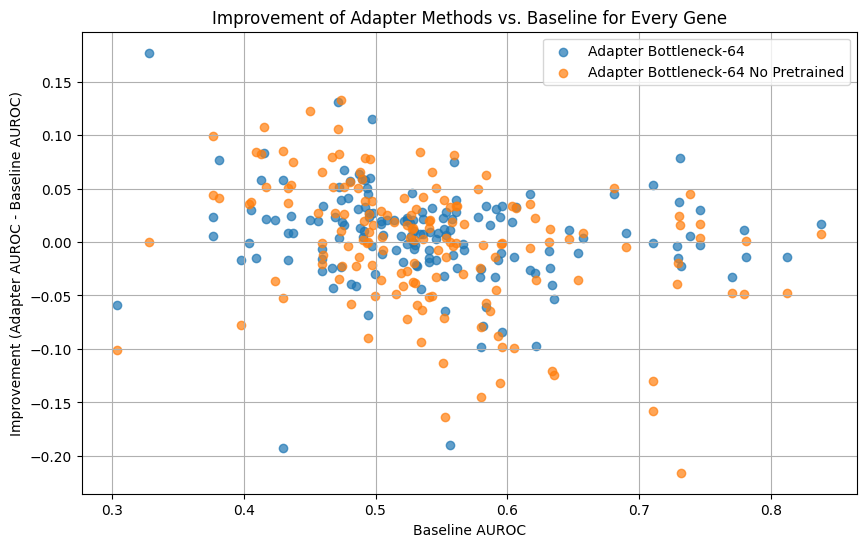

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(merged_df['baseline_auroc'], merged_df['improvement_adapter'], alpha=0.7, label='Adapter Bottleneck-64')
plt.scatter(merged_df['baseline_auroc'], merged_df['improvement_adapter_no_pretrained'], alpha=0.7, label='Adapter Bottleneck-64 No Pretrained')
plt.xlabel('Baseline AUROC')
plt.ylabel('Improvement (Adapter AUROC - Baseline AUROC)')
plt.title('Improvement of Adapter Methods vs. Baseline for Every Gene')
plt.legend()
plt.grid(True)
plt.show()

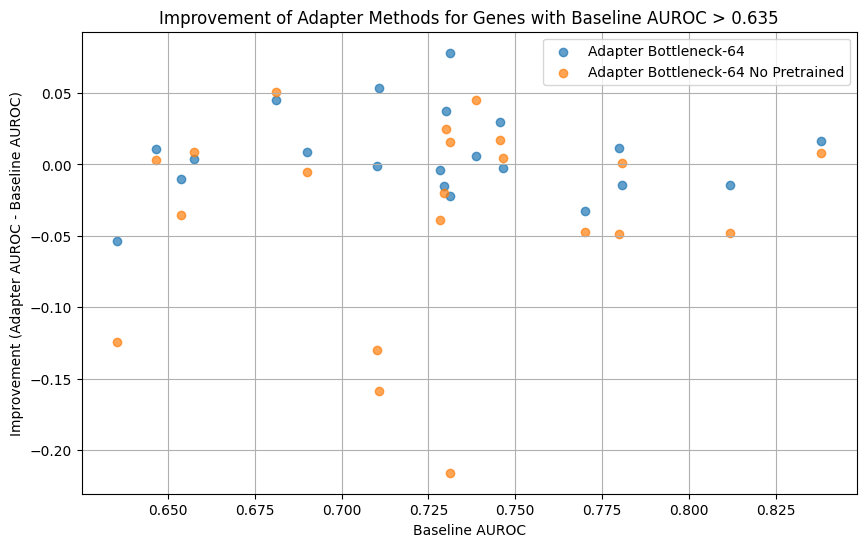

In [50]:
# Filter genes with baseline_auroc > 0.635
df_filtered = merged_df[merged_df['baseline_auroc'] > 0.635]

plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['baseline_auroc'], df_filtered['improvement_adapter'], alpha=0.7, label='Adapter Bottleneck-64')
plt.scatter(df_filtered['baseline_auroc'], df_filtered['improvement_adapter_no_pretrained'], alpha=0.7, label='Adapter Bottleneck-64 No Pretrained')
plt.xlabel('Baseline AUROC')
plt.ylabel('Improvement (Adapter AUROC - Baseline AUROC)')
plt.title('Improvement of Adapter Methods for Genes with Baseline AUROC > 0.635')
plt.legend()
plt.grid(True)
plt.show()


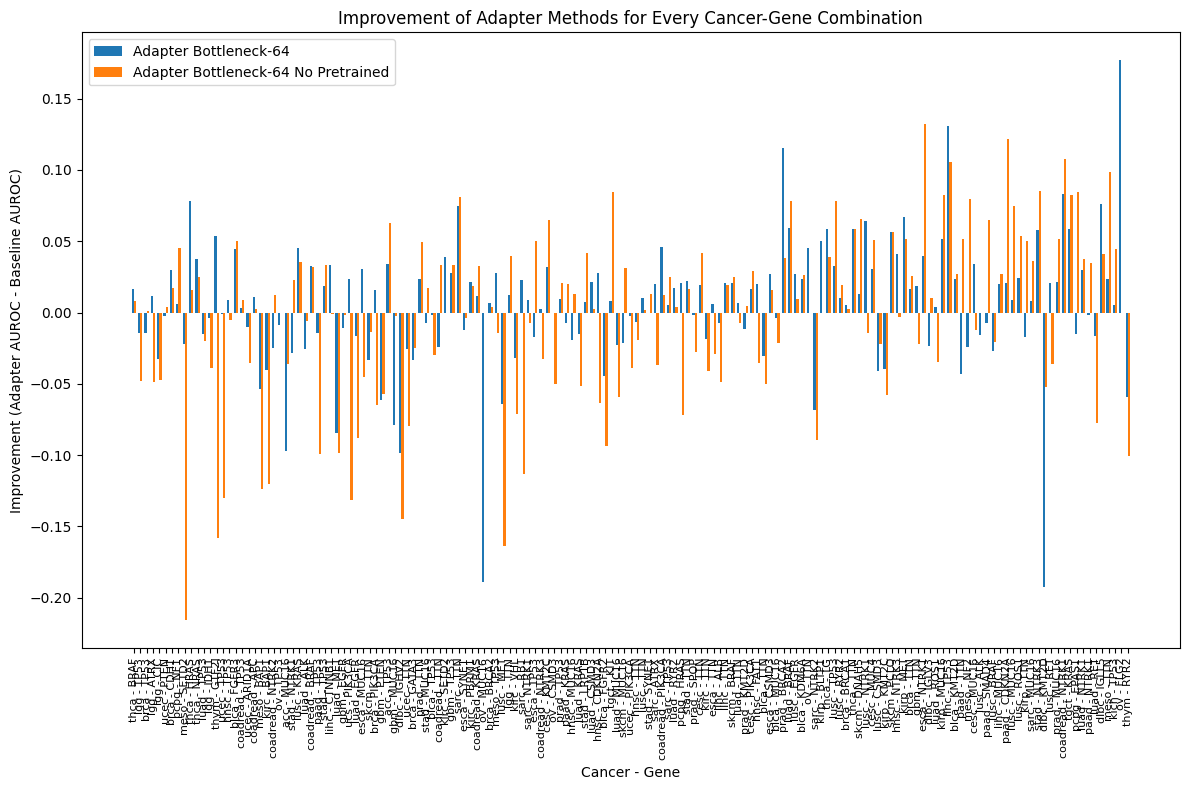

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assume df is already loaded (e.g., from Excel)
# df = pd.read_excel('merged_compared_aurocs.xlsx')

# Compute improvement columns if not already computed
merged_df['improvement_adapter'] = merged_df['auroc-adapter-bottleneck-64'] - merged_df['baseline_auroc']
merged_df['improvement_adapter_no_pretrained'] = merged_df['auroc-adapter-bottleneck-64-no-pretrained'] - merged_df['baseline_auroc']

# Create a combined label column for the x-axis
merged_df['Cancer_Gene'] = merged_df['Cancer'] + ' - ' + merged_df['Gene']

# Set up the bar chart for every cancer-gene combination
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(merged_df))  # each cancer-gene combo gets a bar
width = 0.35

# Plot the two sets of bars side by side
ax.bar(x - width/2, merged_df['improvement_adapter'], width, label='Adapter Bottleneck-64')
ax.bar(x + width/2, merged_df['improvement_adapter_no_pretrained'], width, label='Adapter Bottleneck-64 No Pretrained')

ax.set_xticks(x)
ax.set_xticklabels(merged_df['Cancer_Gene'], rotation=90, fontsize=8)
ax.set_xlabel('Cancer - Gene')
ax.set_ylabel('Improvement (Adapter AUROC - Baseline AUROC)')
ax.set_title('Improvement of Adapter Methods for Every Cancer-Gene Combination')
ax.legend()
plt.tight_layout()
plt.show()


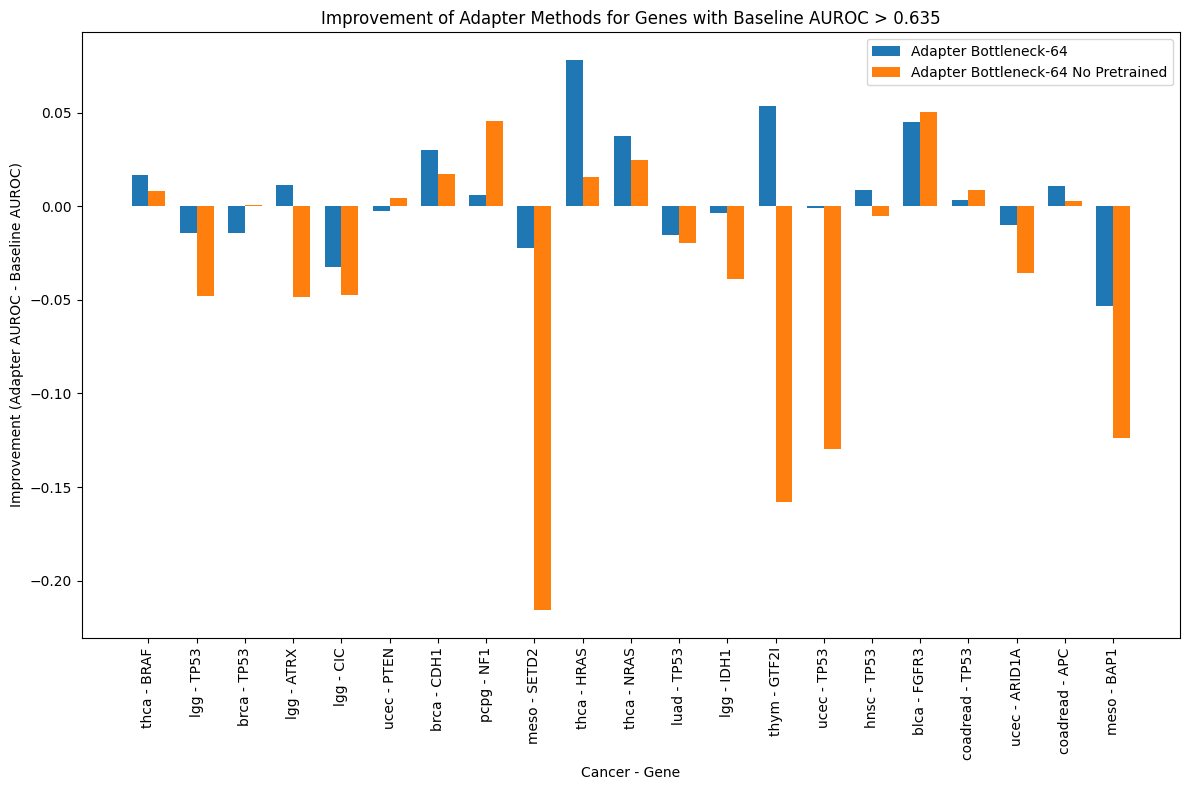

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame for genes with baseline AUROC > 0.635
df_filtered = merged_df[merged_df['baseline_auroc'] > 0.635].copy()

# Create the combined label for the filtered data (if not already present)
df_filtered['Cancer_Gene'] = df_filtered['Cancer'] + ' - ' + df_filtered['Gene']

# Set up the bar chart for the filtered data
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(df_filtered))
width = 0.35

ax.bar(x - width/2, df_filtered['improvement_adapter'], width, label='Adapter Bottleneck-64')
ax.bar(x + width/2, df_filtered['improvement_adapter_no_pretrained'], width, label='Adapter Bottleneck-64 No Pretrained')

ax.set_xticks(x)
ax.set_xticklabels(df_filtered['Cancer_Gene'], rotation=90, fontsize=10)
ax.set_xlabel('Cancer - Gene')
ax.set_ylabel('Improvement (Adapter AUROC - Baseline AUROC)')
ax.set_title('Improvement of Adapter Methods for Genes with Baseline AUROC > 0.635')
ax.legend()
plt.tight_layout()
plt.show()
